In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import uproot 
import scipy.optimize as scipy
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from matplotlib.path import Path
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import pickle
import pickletools
from FV_class import toolbox
from matplotlib.ticker import ScalarFormatter
import math

In [2]:
# Define class object
tb = toolbox()

In [3]:
# define graphical cut 

def graphical_cut(x, y, polygon):
    
    """
    For a given set of (x, y) points, returns a mask
    that applies a graphical cut such that only points
    within the constructed polygon are selected. 
    The polygon should be in the form: [(x1, y1), (x2, y2), ...]
    """
    # # ---------------------------------------------------
    # # below is from chatgpt
    # # Ensure that the polygon has the correct shape
    # if len(polygon.shape) == 1:
    #     polygon = polygon.reshape(-1, 2)
    # # ---------------------------------------------------
    
    # Join datapoints together
    points = np.vstack((x, y)).T 
    
    # Construct polygon and produce mask
    p = Path(polygon)
    mask = p.contains_points(points)
    
    return mask


In [4]:
# define a confidence ellipse function 

def confidence_ellipse(x, y, ax, n_std, facecolor = 'none', **kwargs):

        """
        Based on function from:
        https://matplotlib.org/devdocs/gallery/statistics/confidence_ellipse.html
        
        Create a plot of the covariance confidence ellipse of *x* and *y*.
        
        ----------------------------------------------------------------------
        Parameters
        ----------
        x, y : array-like, shape (n, )
            Input data.

        ax : matplotlib.axes.Axes
            The Axes object to draw the ellipse into.

        n_std : float
            The number of standard deviations to determine the ellipse's radiuses.

        **kwargs
            Forwarded to `~matplotlib.patches.Ellipse`

        Returns
        -------
        matplotlib.patches.Ellipse
        ----------------------------------------------------------------------

        Plots a confidence ellipse for a 2D Gaussian, and returns the mean (x, y)
        with associated standard errors. Also returns the ellipse as a polygon
        to be used for elliptical cuts.
        """

        # Calculate covariance matrix and pearson coefficient
        cov = np.cov(x, y)
        pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])

        # Using a special case to obtain the eigenvalues of 2D dataset
        ell_radius_x = np.sqrt(1 + pearson)
        ell_radius_y = np.sqrt(1 - pearson)
        ellipse = Ellipse((0, 0), width = ell_radius_x * 2, height = ell_radius_y * 2,
                          facecolor = "none", **kwargs)

        # Calculating n_stdevs by square-rooting covariance matrix diagonals
        scale_x = np.sqrt(cov[0, 0]) * n_std
        mean_x = np.mean(x)
        scale_y = np.sqrt(cov[1, 1]) * n_std
        mean_y = np.mean(y)
        n_samples = len(x)

        # For non-plotted version
        if (ax == None):
            return 0, mean_x, mean_y, scale_x, scale_y

        # With plots
        else:
            # Create and add contour ellipse
            transf = transforms.Affine2D() \
                    .rotate_deg(45) \
                    .scale(scale_x, scale_y) \
                    .translate(mean_x, mean_y)
            ellipse.set_transform(transf + ax.transData)
            ell_poly = ax.transData.inverted().transform(ellipse.get_verts())
            return ax.add_patch(ellipse), mean_x, mean_y, scale_x, scale_y, ell_poly


# kjsdnfl

dfkjnfkj

## orsdfo

---


In [5]:
# define function to fit data to confidence ellipse function

def fit_pop_ellipse(S1s, S2s, cuts, poly, nbins = 150, show_plot = True, draw_poly = False,
                        bin_range = ((100, 1e3), (10**2.5, 1e5)), overlay = None,
                        logz = False, save_str = None, ret_fit = False):

        """
        Plots a 2D histogram of S2c vs. S1c, and fits elliptical contours
        to a population specified by a given polygon, with supplied cuts
        applied. Returns a 2-sigma elliptical cut for the population.
        Additional options allow for drawing the original graphical cut, or
        overlaying the elliptical fit of different data.
        """
        
        # create histogram that will do fit without being plotted
        hist = np.histogram2d(S1s[cuts], S2s[cuts], bins = nbins, range = bin_range)
        
        # If overlay is specified
        (S1ov, S2ov, cutsov) = overlay if overlay != None else (S1s, S2s, cuts)

        # Define rough graphical cut
        popcut = graphical_cut(S1ov, S2ov, poly)
        
        # set up subplots
        fig, ax = plt.subplots(figsize = (12, 9))
        
        if show_plot:
            
            # Fit 2D Gaussian to selected population
            h = ax.hist2d(S1s[cuts], S2s[cuts], bins = nbins, range = bin_range, cmin = 1,
                          norm = mplc.LogNorm() if logz else None)
            cb = fig.colorbar(h[3])
            
            # Fit and plot Gaussian contours
            confidence_ellipse(S1ov[cutsov & popcut], S2ov[cutsov & popcut], ax, 1, edgecolor = "r")
            fit = confidence_ellipse(S1ov[cutsov & popcut], S2ov[cutsov & popcut], ax, 2, edgecolor = "r")
            ax.plot(fit[1], fit[2], 'r.') # Draw mean as a point
            
            # Draw polygon if specified
            if draw_poly:
                ax.plot(np.array(poly[:, 0]), np.array(poly[:, 1]), "r--")

            # Formatting
            plt.ticklabel_format(axis = "both", style = "sci", scilimits = (0,0), useMathText = True)
            plt.xlabel(r"S1$_{\mathdefault{c}}$ [phd]")
            plt.ylabel(r"S2$_{\mathdefault{c}}$ [phd]")
            cb.set_label('SS counts')
            if save_str != None:
                plt.savefig("output/{:s}.png".format(save_str), dpi = 300, bbox_inches = 'tight')
            plt.show()
            
        else:
            # Fit Gaussian contours
            confidence_ellipse(S1ov[cutsov & popcut], S2ov[cutsov & popcut], None if ax is None else ax, n_std = 1)
            fit = confidence_ellipse(S1ov[cutsov & popcut], S2ov[cutsov & popcut], None if ax is None else ax, n_std = 1)
            
            # Clear the plot
            ax.clear()
            plt.close(fig)
            
        # Return 2-sigma elliptical cut and fit together if specified
        if ret_fit:
            return graphical_cut(S1s, S2s, fit[-1]), fit
        
        # Otherwise return 2-sigma elliptical cut only
        else: 
            return graphical_cut(S1s, S2s, fit[-1])

In [6]:
# define function that retrieves variable names from list of variables

def get_var_name(var):
    for name, value in globals().items():
        if value is var:
            return name 

In [7]:
# define function to create a dictionary of variables and their associated names 

def create_var_dict(var_list):
    
    # get variable names
    var_names = [get_var_name(var) for var in var_list]
    
    # combine variable_list and variable_name
    var_dict = dict(zip(var_names, var_list))
    
    return var_dict

In [8]:
# define function to take an input dictionary, apply mask to it, return an output dictionary

def apply_mask_to_dict(input_dict, mask, remove_suffix=None, add_suffix=None):
    
    # create blank dictionary
    new_dict = {}
    
    for name, value in input_dict.items():
        
        # apply mask to each variable in input_dict
        new_value = value[mask]
        
        # remove suffix if remove_suffix is specified 
        if remove_suffix:
            name = name.replace(remove_suffix, "")
        
        # add suffix if add_suffix is specified
        if add_suffix:
            new_name = name + add_suffix
        
        else:
            new_name = name 
            
        # fill new_dict with new names and their corresponding new values
        new_dict[new_name] = new_value 
        
    return new_dict
        

In [9]:
# define function to print dictionary keys

def print_keys(var_dict):
    
    # get name of var_dict
    var_dict_name = get_var_name(var_dict)
    print(f"variables in dictionary: {var_dict_name}")
    print()
    for key in var_dict.keys():
        print(key)
    

In [10]:
# load data
data = uproot.open('/global/homes/k/kwild/ALPACA/run/SR3RunsAnalysis/SR3RunsAnalysisInputFiles-WSv4.root')

# get keys
data.keys()

['SS;1']

In [11]:
# select the tree of interest from the file, in this case single scatter events, and get its keys

tree = data['SS;1']
tree.keys()

['runID',
 'eventID',
 'triggerTimeStamp_s',
 'triggerTimeStamp_ns',
 'daq_livetime',
 'trigger_livetime',
 'physics_livetime',
 'SS_raw_S1',
 'SS_raw_S2',
 'SS_raw_S2_top',
 'SS_raw_S2_bot',
 'SS_S1c',
 'SS_S2c',
 'SS_S2c_top',
 'SS_S2c_bot',
 'SS_driftTime_us',
 'SS_X_cm',
 'SS_Y_cm',
 'SS_R_cm',
 'SS_cX_cm',
 'SS_cY_cm',
 'SS_cR_cm',
 'SS_cZ_cm',
 'SS_s1TBA',
 'cxSR1_HSX',
 'cxSR1_SPEX',
 'cxSR1_S1rate',
 'cxSR1_muonV',
 'cxSR1_EA',
 'cxSR1_HSC',
 'cxSR1_stinger',
 'cxSR1_S1shape',
 'cxSR1_S1prom',
 'cxSR1_S1timing',
 'cxSR1_S1TBA',
 'cxSR1_S2TBA',
 'cxSR1_validXY',
 'cxSR1_S2width',
 'cxSR1_narrowS2',
 'cxSR1_S2earlypeak',
 'cxSR1_S2risetime',
 'cxSR1_FCRXY',
 'cxSR1_FV',
 'cxSR1_burst_noise',
 'cxSR1_buffer',
 'cxSR1_skinV',
 'cxSR1_skinVprompt',
 'cxSR1_skinVdel',
 'cxSR1_ODV',
 'cxSR1_ODVprompt',
 'cxSR1_ODVdel',
 'cxSR3_HSX',
 'cxSR3_SPEX',
 'cxSR3_S1rate',
 'cxSR3_muonV',
 'cxSR3_ETV',
 'cxSR3_HSC',
 'cxSR3_stinger',
 'cxSR3_S1TBA',
 'cxSR3_S2TBA',
 'cxSR3_S2XYquality',
 'cxSR

In [12]:
# declare variables
# get the data from the trees

# now including all available SR3 cuts as of 07Nov2023

# signal quality
dT_us = np.array(tree['SS_driftTime_us'])
s1_phd = np.array(tree['SS_raw_S1'])
s2_phd = np.array(tree['SS_raw_S2'])
s1c_phd = np.array(tree['SS_S1c'])
s2c_phd = np.array(tree['SS_S2c'])
x_cm = np.array(tree['SS_X_cm'])
y_cm = np.array(tree['SS_Y_cm'])
r2_cm2 = x_cm**2 + y_cm**2

# pulse info
eventID = np.array(tree['eventID'])
runID = np.array(tree['runID'])
trigTime_s_POSIX = np.array(tree['triggerTimeStamp_s'])
trigTime_ns_past_POSIX = np.array(tree['triggerTimeStamp_ns'])

# vetoes
cxSR1_HSX = np.array(tree['cxSR1_HSX'])
cxSR1_SPEX = np.array(tree['cxSR1_SPEX'])
cxSR1_S1rate = np.array(tree['cxSR1_S1rate'])
cxSR1_muonV = np.array(tree['cxSR1_muonV'])
cxSR1_EA = np.array(tree['cxSR1_EA'])
cxSR1_HSC = np.array(tree['cxSR1_HSC'])
cxSR1_stinger = np.array(tree['cxSR1_stinger'])
cxSR1_S1shape = np.array(tree['cxSR1_S1shape'])
cxSR1_S1prom = np.array(tree['cxSR1_S1prom'])
cxSR1_S1timing = np.array(tree['cxSR1_S1timing'])
cxSR1_S1TBA = np.array(tree['cxSR1_S1TBA'])
cxSR1_S2TBA = np.array(tree['cxSR1_S2TBA'])
cxSR1_validXY = np.array(tree['cxSR1_validXY'])
cxSR1_S2width = np.array(tree['cxSR1_S2width'])
cxSR1_narrowS2 = np.array(tree['cxSR1_narrowS2'])
cxSR1_S2earlypeak = np.array(tree['cxSR1_S2earlypeak'])
cxSR1_S2risetime = np.array(tree['cxSR1_S2risetime'])
cxSR1_FCRXY = np.array(tree['cxSR1_FCRXY'])
cxSR1_FV = np.array(tree['cxSR1_FV'])
cxSR1_burst_noise = np.array(tree['cxSR1_burst_noise'])
cxSR1_buffer = np.array(tree['cxSR1_buffer'])
cxSR1_skinV = np.array(tree['cxSR1_skinV'])
cxSR1_skinVprompt = np.array(tree['cxSR1_skinVprompt'])
cxSR1_skinVdel = np.array(tree['cxSR1_skinVdel'])
cxSR1_ODV = np.array(tree['cxSR1_ODV'])
cxSR1_ODVprompt = np.array(tree['cxSR1_ODVprompt'])
cxSR1_ODVdel = np.array(tree['cxSR1_ODVdel'])
cxSR3_HSX = np.array(tree['cxSR3_HSX'])
cxSR3_SPEX = np.array(tree['cxSR3_SPEX'])
cxSR3_S1rate = np.array(tree['cxSR3_S1rate'])
cxSR3_muonV = np.array(tree['cxSR3_muonV'])
cxSR3_ETV = np.array(tree['cxSR3_ETV'])
cxSR3_HSC = np.array(tree['cxSR3_HSC'])
cxSR3_stinger = np.array(tree['cxSR3_stinger'])
cxSR3_S1TBA = np.array(tree['cxSR3_S1TBA'])
cxSR3_S2TBA = np.array(tree['cxSR3_S2TBA'])
cxSR3_S2XYquality = np.array(tree['cxSR3_S2XYquality'])
cxSR3_S2width = np.array(tree['cxSR3_S2width'])
cxSR3_narrowS2 = np.array(tree['cxSR3_narrowS2'])
cxSR3_S2earlypeak = np.array(tree['cxSR3_S2earlypeak'])
cxSR3_S2risetime = np.array(tree['cxSR3_S2risetime'])
cxSR3_FCRXY = np.array(tree['cxSR3_FCRXY'])
cxSR3_burst_noise = np.array(tree['cxSR3_burst_noise'])
cxSR3_buffer = np.array(tree['cxSR3_buffer'])
cxSR3_SSwindow = np.array(tree['cxSR3_SSwindow'])
cxSR3_skinV = np.array(tree['cxSR3_skinV'])
cxSR3_skinVprompt = np.array(tree['cxSR3_skinVprompt'])
cxSR3_skinVdel = np.array(tree['cxSR3_skinVdel'])
cxSR3_ODV = np.array(tree['cxSR3_ODV'])
cxSR3_ODVprompt = np.array(tree['cxSR3_ODVprompt'])
cxSR3_ODVdel = np.array(tree['cxSR3_ODVdel'])

In [13]:
# get timestamps for each data point 
trigT_s = trigTime_s_POSIX + (1e-9 * trigTime_ns_past_POSIX)

In [14]:
# view data 

# set up figure and axes
fig, ax = plt.subplots(figsize=(12,6))

# set up bin numbers and ranges 
num_bins = 100
plot_range = [[0,1500], [0,2000000]]

# SS log(S2c) vs S1c
h = ax.hist2d(s1c_phd,s2c_phd, bins = num_bins, range = plot_range, norm = colors.LogNorm()) #, cmin=1)
ax.set_xlabel('S1c [phd]')
ax.set_ylabel('S2c [phd]')
ax.set_title('')
cbar = fig.colorbar(h[3], ax=ax)
cbar.set_label('Counts / Bin')

In [15]:
# reconstructed energy of electron recoils
# look at paper: Background Determination for the LUX-ZEPLIN (LZ) Dark Matter Experiment

# declare constants
# # global constants
# W : 13.5e-3 #[keV]
# g1 : 0.1148 #[phd/ph]
# g2 : 36.23 #[phd/e-]
W = 13.5 # eV/event
g1 = 0.1148 # photons detected [phd] / phonon
g2 = 36.23 # photons detected [phd] / e-

# caluclate reconstructed energy of signal and divde by 1000 to convert to keV
Erec = W * ((s1c_phd / g1) + (s2c_phd / g2)) / 1000. 

# Set up the figure and axes for subplots
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

# set the range and the number of bins
num_bins = 300
plot_range = (0.,300.)

# set up histogram with all data cuts 
h_Erec = ax.hist(Erec, bins = num_bins, range=plot_range, histtype='step', color='xkcd:cobalt', linewidth=1)
ax.hist(Erec, bins = num_bins, range=plot_range, histtype='stepfilled', alpha=0.5, color='xkcd:sky blue')

# plot vertical lines at reconstructed energy range of Xe 131m (about 164 keV)
# x131m_low = 150 #keV
# x131m_high = 185 #keV
# ax.axvline(x131m_low, color='red', linestyle='--', label='150 keV')
# ax.axvline(x131m_high, color='red', linestyle='--', label='185 keV')
x131m_low = 140 #keV
x131m_high = 195 #keV
ax.axvline(x131m_low, color='red', linestyle='--', label='140 keV')
ax.axvline(x131m_high, color='red', linestyle='--', label='195 keV')
ax.legend()

# plot histogram
ax.set_xlabel('Reconstructed Energy (keV)', fontsize=10)
ax.set_ylabel('log$_{10}$ (counts)', fontsize=10)
ax.set_title('Xe 131m Energy Spectrum (No Cuts)', fontsize=12)
# Set y-axis scale to log base 10
ax.set_yscale('log')
#ax2.set_xlim(0, 500)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.legend(fontsize=10)

# Add main title above the subplots
main_title = "SR3v8 LZAP-5.5.3"
fig.suptitle(main_title, y=1.01, fontsize=16)

Text(0.5, 1.01, 'SR3v8 LZAP-5.5.3')

In [16]:
# create mask to exclude data outside reconstructed energy = 150 - 170 keV (expected value ~164 keV)
# s1c and s2c space

rough_xe131m_cond = (Erec > x131m_low) & (Erec < x131m_high) #& \
                    # (np.log10(s1c_phd) > 2.89) & (np.log10(s1c_phd) < 3.09) & \
                    # (np.log10(s2c_phd) > 4.95) & (np.log10(s2c_phd) < 5.35)

In [17]:
# define condition that will remove all events that don't pass vetoes

# vetoes
veto_list = (cxSR3_HSX,cxSR3_SPEX,cxSR3_S1rate,cxSR3_muonV,cxSR3_ETV,cxSR3_HSC,cxSR3_stinger,cxSR3_S1TBA,cxSR3_S2TBA,
             cxSR3_S2XYquality,cxSR3_S2width,cxSR3_narrowS2,cxSR3_S2earlypeak,cxSR3_S2risetime,cxSR3_FCRXY,cxSR3_burst_noise,
             cxSR3_buffer,cxSR3_SSwindow,cxSR3_skinV,cxSR3_skinVprompt,cxSR3_skinVdel,cxSR3_ODV,cxSR3_ODVprompt,cxSR3_ODVdel) 

# create blank conditions list
veto_cond = np.ones_like(cxSR1_HSX, dtype=bool)

for i in veto_list:
    veto_cond = veto_cond & i 

In [18]:
# define condition that 

# make mask to limit values in dT_fit to the range [65, 1044]

# drift time limits
min_dT = 65.
max_dT = 1044.

dT_cond = (dT_us > min_dT) & (dT_us < max_dT)

In [19]:
# define mask with all above conditions 

cuts = rough_xe131m_cond & dT_cond # & veto_cond
# print(len(cuts))
# print(sum(cuts))

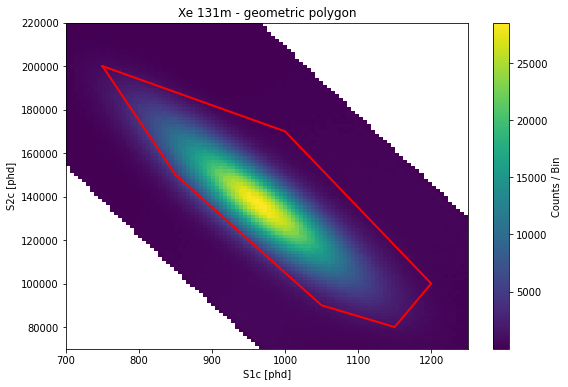

In [20]:
# create mask using graphical_cut function 

# Define a polygon for main Xe131m population and create cut
# # these are for log10 s1c log10 s2c space
# polygon_main = [ (2.91,5.3), (3.01,5.22), (3.06,5.02), (3.02,5.0), (2.94,5.15), (2.91,5.3) ]
# xe131m_mask_poly = graphical_cut(np.log10(s1c_phd), np.log10(s2c_phd), polygon_main)

# define polygon shape 
polygon_main = [ (750,20e4), (1e3,17e4), (1.2e3,10e4), (1.15e3,8e4), (1.05e3,9e4), (850,15e4), (750,20e4) ]

# plot polygon on histo to test 

# set up figure and axes
fig, ax = plt.subplots(figsize=(9,6))

# set up bin numbers and ranges 
num_bins = 100
plot_range = [[700,1250], [7e4,22e4]]

# SS log(S2c) vs S1c
h_poly = ax.hist2d(s1c_phd[cuts],s2c_phd[cuts], bins = num_bins, range = plot_range, cmin=1)
ax.set_xlabel('S1c [phd]', fontsize=10)
ax.set_ylabel('S2c [phd]', fontsize=10)
ax.set_title('Xe 131m - geometric polygon', fontsize=12)
cbar = fig.colorbar(h_poly[3], ax=ax)
cbar.set_label('Counts / Bin', fontsize=10)

polygon_x_main, polygon_y_main = zip(*polygon_main)
ax.plot(polygon_x_main, polygon_y_main, lw = 2, color = "red")

ax.tick_params(axis='both', which='major', labelsize=10)
cbar.ax.tick_params(axis='y', labelsize=10)
# ax.legend(fontsize=10)


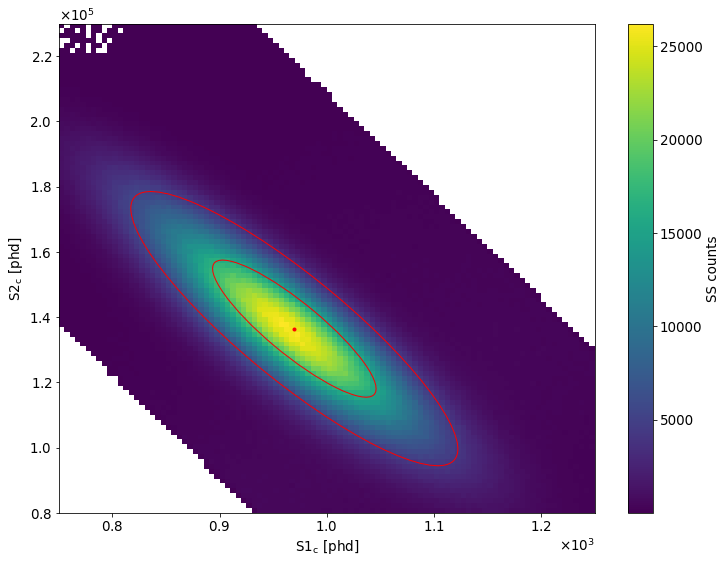

In [21]:
# fit data to polygon cut

plot_range = [[0.75e3,1.25e3], [0.8e5,2.3e5]]
ell_mask = fit_pop_ellipse(S1s=s1c_phd, S2s=s2c_phd, cuts=cuts, poly=polygon_main, \
                           nbins = 100, draw_poly = False, bin_range=plot_range, \
                           overlay = None, logz = False, save_str = None, ret_fit = False)


In [22]:
# create variable dictionary 

rqs_list = dT_us, s1_phd, s2_phd, s1c_phd, s2c_phd, x_cm, y_cm, r2_cm2, \
            eventID, runID, trigTime_s_POSIX, trigTime_ns_past_POSIX, trigT_s

rqs_dict = create_var_dict(rqs_list)
print_keys(rqs_dict)

variables in dictionary: rqs_dict

dT_us
s1_phd
s2_phd
s1c_phd
s2c_phd
x_cm
y_cm
r2_cm2
eventID
runID
trigTime_s_POSIX
trigTime_ns_past_POSIX
trigT_s


In [23]:
# apply data cuts to variable dictionary rqs_dict

rqs_dict_post_cuts = apply_mask_to_dict(input_dict=rqs_dict, mask=cuts , remove_suffix=None, add_suffix="_post_cuts")
print_keys(rqs_dict_post_cuts)

variables in dictionary: rqs_dict_post_cuts

dT_us_post_cuts
s1_phd_post_cuts
s2_phd_post_cuts
s1c_phd_post_cuts
s2c_phd_post_cuts
x_cm_post_cuts
y_cm_post_cuts
r2_cm2_post_cuts
eventID_post_cuts
runID_post_cuts
trigTime_s_POSIX_post_cuts
trigTime_ns_past_POSIX_post_cuts
trigT_s_post_cuts


In [24]:
# variables from rqs_dict_cuts

dT_us_post_cuts = rqs_dict_post_cuts['dT_us_post_cuts']
s1_phd_post_cuts = rqs_dict_post_cuts['s1_phd_post_cuts']
s2_phd_post_cuts = rqs_dict_post_cuts['s2_phd_post_cuts']
s1c_phd_post_cuts = rqs_dict_post_cuts['s1c_phd_post_cuts']
s2c_phd_post_cuts = rqs_dict_post_cuts['s2c_phd_post_cuts']
x_cm_post_cuts = rqs_dict_post_cuts['x_cm_post_cuts']
y_cm_post_cuts = rqs_dict_post_cuts['y_cm_post_cuts']
r2_cm2_post_cuts = rqs_dict_post_cuts['r2_cm2_post_cuts']
eventID_post_cuts = rqs_dict_post_cuts['eventID_post_cuts']
runID_post_cuts = rqs_dict_post_cuts['runID_post_cuts']
trigTime_s_POSIX_post_cuts = rqs_dict_post_cuts['trigTime_s_POSIX_post_cuts']
trigTime_ns_past_POSIX_post_cuts = rqs_dict_post_cuts['trigTime_ns_past_POSIX_post_cuts']
trigT_s_post_cuts = rqs_dict_post_cuts['trigT_s_post_cuts']

In [25]:
# apply 2 sigma mask to rqs_dict_cuts to get rqs_dict_2sig

rqs_dict_2sig = apply_mask_to_dict(input_dict=rqs_dict, mask=ell_mask, remove_suffix=None, add_suffix="_2sig")
print_keys(rqs_dict_2sig)

variables in dictionary: rqs_dict_2sig

dT_us_2sig
s1_phd_2sig
s2_phd_2sig
s1c_phd_2sig
s2c_phd_2sig
x_cm_2sig
y_cm_2sig
r2_cm2_2sig
eventID_2sig
runID_2sig
trigTime_s_POSIX_2sig
trigTime_ns_past_POSIX_2sig
trigT_s_2sig


In [26]:
# variables from rq_dict_2sig

dT_us_2sig = rqs_dict_2sig['dT_us_2sig']
s1_phd_2sig = rqs_dict_2sig['s1_phd_2sig']
s2_phd_2sig = rqs_dict_2sig['s2_phd_2sig']
s1c_phd_2sig = rqs_dict_2sig['s1c_phd_2sig']
s2c_phd_2sig = rqs_dict_2sig['s2c_phd_2sig']
x_cm_2sig = rqs_dict_2sig['x_cm_2sig']
y_cm_2sig = rqs_dict_2sig['y_cm_2sig']
r2_cm2_2sig = rqs_dict_2sig['r2_cm2_2sig']
eventID_2sig = rqs_dict_2sig['eventID_2sig']
runID_2sig = rqs_dict_2sig['runID_2sig']
trigTime_s_POSIX_2sig = rqs_dict_2sig['trigTime_s_POSIX_2sig']
trigTime_ns_past_POSIX_2sig = rqs_dict_2sig['trigTime_ns_past_POSIX_2sig']
trigT_s_2sig = rqs_dict_2sig['trigT_s_2sig']

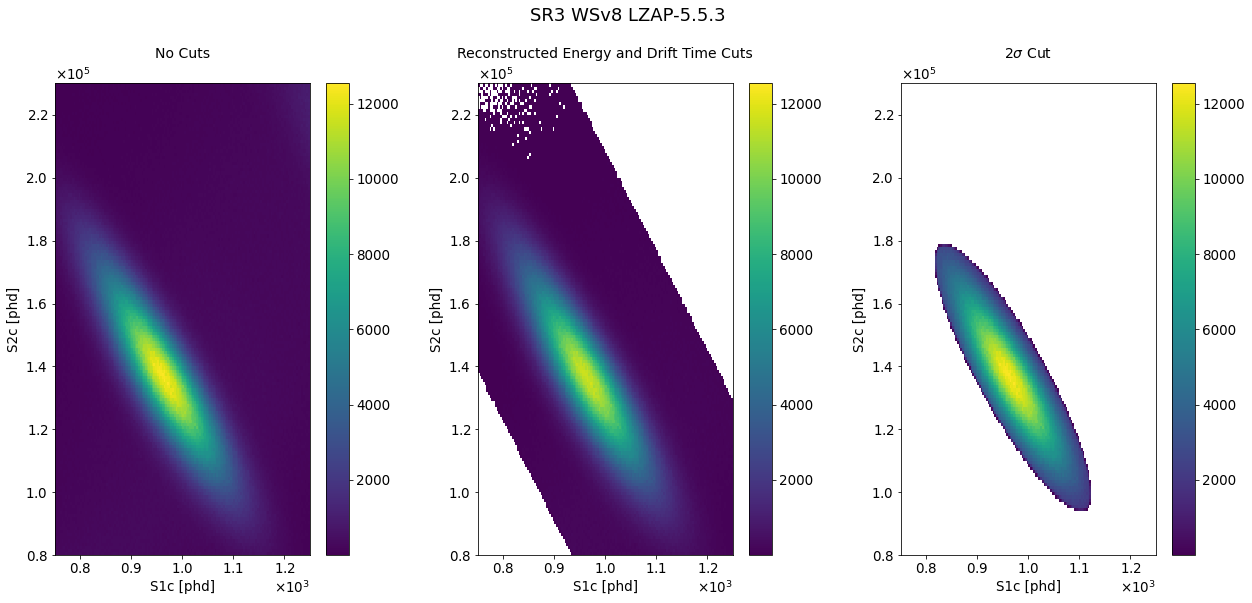

In [27]:
# plot S2c vs. S1c for no cuts vs. 2 sigma cut 

# Set up the figure and axes for subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 9))

# set up bin numbers and ranges 
num_bins = 150
plot_range = [[0.75e3,1.25e3], [0.8e5,2.3e5]]

# no cuts 
h1 = ax1.hist2d(s1c_phd, s2c_phd, bins = num_bins, range = plot_range, cmin = 1)#, norm = colors.LogNorm())
ax1.set_xlabel('S1c [phd]')
ax1.set_ylabel('S2c [phd]')
ax1.set_title('No Cuts', y=1.04, fontsize=14)

# reconstructed energy and drift time cut 
h2 = ax2.hist2d(s1c_phd_post_cuts, s2c_phd_post_cuts, bins = num_bins, range = plot_range, cmin = 1)#, norm = colors.LogNorm())
ax2.set_xlabel('S1c [phd]')
ax2.set_ylabel('S2c [phd]')
ax2.set_title('Reconstructed Energy and Drift Time Cuts', y=1.04, fontsize=14)

# reconstructed energy and drift time cut 
h3 = ax3.hist2d(s1c_phd_2sig, s2c_phd_2sig, bins = num_bins, range = plot_range, cmin = 1)#, norm = colors.LogNorm())
ax3.set_xlabel('S1c [phd]')
ax3.set_ylabel('S2c [phd]')
ax3.set_title('2$\sigma$ Cut', y=1.04, fontsize=14)

# Add colorbars
# get max across all histograms
vmin = 1
vmax = max(np.max(h1[0]), np.max(h2[0]), np.max(h3[0]))
# Set color limits for histograms
h1[3].set_clim(vmin, vmax)
h2[3].set_clim(vmin, vmax)
h3[3].set_clim(vmin, vmax)
# Add colorbars to the plots
cbar1 = fig.colorbar(h1[3], ax=ax1)
cbar2 = fig.colorbar(h2[3], ax=ax2)
cbar3 = fig.colorbar(h3[3], ax=ax3)

# Add labels 
main_title = "SR3 WSv8 LZAP-5.5.3"
plt.suptitle(main_title, y=.95, fontsize=18)

# convert axis numbers to scientific notation
ax1.ticklabel_format(axis = "both", style = "sci", scilimits = (0,0), useMathText = True)
ax2.ticklabel_format(axis = "both", style = "sci", scilimits = (0,0), useMathText = True)
ax3.ticklabel_format(axis = "both", style = "sci", scilimits = (0,0), useMathText = True)

# Adjust spacing between subplots
fig.tight_layout(pad=2.0)

In [28]:
# plot S2c vs. S1c for no cuts vs. 2 sigma cut 

# Set up the figure and axes for subplots
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(18, 12))

# set the number of bins and range for y_cm vs. x_cm
num_bins_1 = 100
plot_range_1 = [[-73., 73.], [-73., 73.]]

# set up bin numbers and ranges for dT vs. r^2 plot
# dT >= 60, dT <= 1044
num_bins_2 = 150
plot_range_2 = [[3500.,6000.], [-100.,1200.]]

# no cuts 
h1 = ax1.hist2d(x_cm, y_cm, bins = num_bins_1, range = plot_range_1, norm = colors.LogNorm())
ax1.set_xlabel('x [cm]', fontsize=10)
ax1.set_ylabel('y [cm]', fontsize=10)
ax1.set_title('No Cuts', y=1.02, fontsize=14)

# reconstructed energy and drift time cut 
h2 = ax2.hist2d(x_cm_post_cuts, y_cm_post_cuts, bins = num_bins_1, range = plot_range_1, norm = colors.LogNorm())
ax2.set_xlabel('x [cm]', fontsize=10)
ax2.set_ylabel('y [cm]', fontsize=10)
ax2.set_title('Reconstructed Energy and Drift Time Cuts', y=1.02, fontsize=14)

# reconstructed energy and drift time cut 
h3 = ax3.hist2d(x_cm_2sig, y_cm_2sig, bins = num_bins_1, range = plot_range_1, norm = colors.LogNorm())
ax3.set_xlabel('x [cm]', fontsize=10)
ax3.set_ylabel('y [cm]', fontsize=10)
ax3.set_title('2$\sigma$ Cut', y=1.02, fontsize=14)

# reconstructed energy and drift time cut 
h4 = ax4.hist2d(r2_cm2, dT_us, bins = num_bins_2, range = plot_range_2, norm = colors.LogNorm())
ax4.set_xlabel('$r^2$ [${cm}^2$]', fontsize=10)
ax4.set_ylabel('dT [$\mu$s]', fontsize=10)
ax4.set_title('No Cuts', y=1.02, fontsize=14)

# reconstructed energy and drift time cut 
h5 = ax5.hist2d(r2_cm2_post_cuts, dT_us_post_cuts, bins = num_bins_2, range = plot_range_2, norm = colors.LogNorm())
ax5.set_xlabel('$r^2$ [${cm}^2$]', fontsize=10)
ax5.set_ylabel('dT [$\mu$s]', fontsize=10)
ax5.set_title('Reconstructed Energy and Drift Time Cuts', y=1.02, fontsize=14)

# reconstructed energy and drift time cut 
h6 = ax6.hist2d(r2_cm2_2sig, dT_us_2sig, bins = num_bins_2, range = plot_range_2, norm = colors.LogNorm())
ax6.set_xlabel('$r^2$ [${cm}^2$]', fontsize=10)
ax6.set_ylabel('dT [$\mu$s]', fontsize=10)
ax6.set_title('2$\sigma$ Cut', y=1.02, fontsize=14)

# Add colorbars
# get max across all y vs. x histograms
vmin_1 = 1
vmax_1 = max(np.max(h1[0]), np.max(h2[0]), np.max(h3[0]))
# Set color limits for histograms
h1[3].set_clim(vmin_1, vmax_1)
h2[3].set_clim(vmin_1, vmax_1)
h3[3].set_clim(vmin_1, vmax_1)
# Add colorbars to the plots
cbar1 = fig.colorbar(h1[3], ax=ax1)
cbar2 = fig.colorbar(h2[3], ax=ax2)
cbar3 = fig.colorbar(h3[3], ax=ax3)
# get max across all histograms
vmin_2 = 1
vmax_2 = max(np.max(h4[0]), np.max(h5[0]), np.max(h6[0]))
# Set color limits for histograms
h4[3].set_clim(vmin_2, vmax_2)
h5[3].set_clim(vmin_2, vmax_2)
h6[3].set_clim(vmin_2, vmax_2)
# Add colorbars to the plots
cbar4 = fig.colorbar(h1[3], ax=ax4)
cbar5 = fig.colorbar(h2[3], ax=ax5)
cbar6 = fig.colorbar(h3[3], ax=ax6)

# Add labels 
main_title = "SR3 WSv8 LZAP-5.5.3"
plt.suptitle(main_title, y=.95, fontsize=18)

# Adjust spacing between subplots
fig.tight_layout(pad=2.0)

# Flip the y-axis for specific subplots
ax4.invert_yaxis()
ax5.invert_yaxis()
ax6.invert_yaxis()

# adjust text size of axis ticks
ax1.tick_params(axis='both', which='major', labelsize=10)
cbar1.ax.tick_params(axis='y', labelsize=10)
ax2.tick_params(axis='both', which='major', labelsize=10)
cbar2.ax.tick_params(axis='y', labelsize=10)
ax3.tick_params(axis='both', which='major', labelsize=10)
cbar3.ax.tick_params(axis='y', labelsize=10)
ax4.tick_params(axis='both', which='major', labelsize=10)
cbar4.ax.tick_params(axis='y', labelsize=10)
ax5.tick_params(axis='both', which='major', labelsize=10)
cbar5.ax.tick_params(axis='y', labelsize=10)
ax6.tick_params(axis='both', which='major', labelsize=10)
cbar6.ax.tick_params(axis='y', labelsize=10)

In [29]:
# define function to get time intervals stored in a dictionary 

def get_time_ints(t_bins, times):
    
    # create histogram of counts in bins of timestamps
    counts, t_edges = np.histogram(times, bins=t_bins)
    
    # create empty dictionary of info about time intervals
    time_int_dict = {}
    
    for i in range(t_bins):
        
        # get start and end times of each time bin
        t_start        = tb.convert_UTC_to_MT(t_edges[i])
        t_end          = tb.convert_UTC_to_MT(t_edges[i + 1])
        t_title_string = f'{t_start.day} {t_start.strftime("%b")}. {t_start.year} – ' \
                         f'{t_end.day} {t_end.strftime("%b")}. {t_end.year}'
        
        # create time interval mask
        t_mask = (times >= t_edges[i]) & (times < t_edges[i+1])
    
        # fill time_int_dict with 
        time_int_dict[i] = t_mask, t_start, t_end, t_title_string
        
    return time_int_dict

"""
I need the names to correspond to the actual data. Let's define a new function, similar to this one that is called get_time_ints_no_empty_days. 
We will supply it additionally with t_bins_fine = 140, to denote approximately 1-day time intervals. 
The function should put these into the histogram as it does here, then create a mask (which it needs to return as no_empty_days_mask) 
to remove any empty bins, and apply that mask. Then, it will take the bins that remain of the original 140, and split them
into t_bins=20 intervals based on evenly dividing the remaining bins, allowing the last bin to have fewer entries if required
"""

"\nI need the names to correspond to the actual data. Let's define a new function, similar to this one that is called get_time_ints_no_empty_days. \nWe will supply it additionally with t_bins_fine = 140, to denote approximately 1-day time intervals. \nThe function should put these into the histogram as it does here, then create a mask (which it needs to return as no_empty_days_mask) \nto remove any empty bins, and apply that mask. Then, it will take the bins that remain of the original 140, and split them\ninto t_bins=20 intervals based on evenly dividing the remaining bins, allowing the last bin to have fewer entries if required\n"

In [30]:
# create time intervals and store in dictionary

time_int_dict = get_time_ints(t_bins = 25, times = trigT_s)

# Print t_title_string 
for key, value in time_int_dict.items():
    
    # unpack time_int_dict
    t_mask, t_start, t_end, t_title_string = value
    
    # print title string for each
    print(f"Time interval {key}: {t_title_string}")

# get and print info about time intervals 
time_int_len   = len(time_int_dict)
time_int_first = time_int_dict[list(time_int_dict)[0]][3]
time_int_last  = time_int_dict[list(time_int_dict)[-1]][3]

print()
print(f'There are {time_int_len} time intervals.')
print()
print(f'The first time interval is: {time_int_first}')
print(f'The last time interval is : {time_int_last}')

Time interval 0: 27 Mar. 2023 – 9 Apr. 2023
Time interval 1: 9 Apr. 2023 – 22 Apr. 2023
Time interval 2: 22 Apr. 2023 – 6 May. 2023
Time interval 3: 6 May. 2023 – 19 May. 2023
Time interval 4: 19 May. 2023 – 1 Jun. 2023
Time interval 5: 1 Jun. 2023 – 14 Jun. 2023
Time interval 6: 14 Jun. 2023 – 27 Jun. 2023
Time interval 7: 27 Jun. 2023 – 10 Jul. 2023
Time interval 8: 10 Jul. 2023 – 23 Jul. 2023
Time interval 9: 23 Jul. 2023 – 5 Aug. 2023
Time interval 10: 5 Aug. 2023 – 18 Aug. 2023
Time interval 11: 18 Aug. 2023 – 1 Sep. 2023
Time interval 12: 1 Sep. 2023 – 14 Sep. 2023
Time interval 13: 14 Sep. 2023 – 27 Sep. 2023
Time interval 14: 27 Sep. 2023 – 10 Oct. 2023
Time interval 15: 10 Oct. 2023 – 23 Oct. 2023
Time interval 16: 23 Oct. 2023 – 5 Nov. 2023
Time interval 17: 5 Nov. 2023 – 18 Nov. 2023
Time interval 18: 18 Nov. 2023 – 1 Dec. 2023
Time interval 19: 1 Dec. 2023 – 15 Dec. 2023
Time interval 20: 15 Dec. 2023 – 28 Dec. 2023
Time interval 21: 28 Dec. 2023 – 10 Jan. 2024
Time interva

In [31]:
# get shorter time intervals to figure out which intervals are empty

time_int_one_day_ints_dict = get_time_ints(t_bins = 140, times = trigT_s)


In [32]:
# figure out which of the intervals are empty 

# Print t_title_string 
for key, value in time_int_one_day_ints_dict.items():
    
    # unpack time_int_dict
    t_mask, t_start, t_end, t_title_string = value
    
    # print title string for each
    print(f"Time interval {key}: {t_title_string}")

# get and print info about time intervals 
time_int_one_day_ints_len   = len(time_int_one_day_ints_dict)
time_int_one_day_ints_first = time_int_one_day_ints_dict[list(time_int_one_day_ints_dict)[0]][3]
time_int_one_day_ints_last  = time_int_one_day_ints_dict[list(time_int_one_day_ints_dict)[-1]][3]

print()
print(f'There are {time_int_one_day_ints_len} time intervals.')
print()
print(f'The first time interval is: {time_int_one_day_ints_first}')
print(f'The last time interval is : {time_int_one_day_ints_last}')

Time interval 0: 27 Mar. 2023 – 30 Mar. 2023
Time interval 1: 30 Mar. 2023 – 1 Apr. 2023
Time interval 2: 1 Apr. 2023 – 3 Apr. 2023
Time interval 3: 3 Apr. 2023 – 6 Apr. 2023
Time interval 4: 6 Apr. 2023 – 8 Apr. 2023
Time interval 5: 8 Apr. 2023 – 10 Apr. 2023
Time interval 6: 10 Apr. 2023 – 13 Apr. 2023
Time interval 7: 13 Apr. 2023 – 15 Apr. 2023
Time interval 8: 15 Apr. 2023 – 17 Apr. 2023
Time interval 9: 17 Apr. 2023 – 20 Apr. 2023
Time interval 10: 20 Apr. 2023 – 22 Apr. 2023
Time interval 11: 22 Apr. 2023 – 24 Apr. 2023
Time interval 12: 24 Apr. 2023 – 27 Apr. 2023
Time interval 13: 27 Apr. 2023 – 29 Apr. 2023
Time interval 14: 29 Apr. 2023 – 1 May. 2023
Time interval 15: 1 May. 2023 – 4 May. 2023
Time interval 16: 4 May. 2023 – 6 May. 2023
Time interval 17: 6 May. 2023 – 8 May. 2023
Time interval 18: 8 May. 2023 – 11 May. 2023
Time interval 19: 11 May. 2023 – 13 May. 2023
Time interval 20: 13 May. 2023 – 15 May. 2023
Time interval 21: 15 May. 2023 – 18 May. 2023
Time interval 

In [33]:
def find_and_mask_empty_intervals(time_intervals_dict, total_intervals):
    empty_intervals_mask = [True] * total_intervals  # Initialize mask with all intervals included
    empty_intervals_list = []
    for index, (t_mask, _, _, _) in time_intervals_dict.items():
        if all(not mask for mask in t_mask):
            empty_intervals_mask[index] = False  # Set the corresponding interval to False in the mask
            empty_intervals_list.append(index)  # Add the index to the list of empty intervals
    return empty_intervals_mask, empty_intervals_list

In [34]:


empty_time_bins_mask, empty_time_bins = find_and_mask_empty_intervals(time_int_one_day_ints_dict, time_int_one_day_ints_len)

print("Remove empty intervals mask (False are empty):", empty_time_bins_mask)
print(f"length of mask:       {len(empty_time_bins_mask)}")
print()
print("Empty intervals list:", empty_time_bins)
print(f"length of list:       {len(empty_time_bins)}")
print()
print(f"no. of true elements: {time_int_one_day_ints_len - len(empty_time_bins)}")



Remove empty intervals mask (False are empty): [True, True, True, True, True, True, True, True, True, True, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, True, True, True, True, True, True, False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, False, False, False, False, False, False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]
length of mask:       140

Empty intervals list: [11, 12, 13, 14, 15, 16, 17, 18, 

In [35]:
print(f"no. of true elements: {np.sum(empty_time_bins_mask)}")

no. of true elements: 110


In [36]:
def get_time_ints_no_empty_days(t_bins_fine, t_bins_coarse, rqs_dict, cuts, veto_list, x131m_low = 140, x131m_high = 195):
    
    # apply cuts to rqs_dict
    masked_rqs_dict = {key: value[cuts] for key, value in rqs_dict.items()}
    
    # get values out of rqs_dict
    times = masked_rqs_dict['trigT_s']
    r2    = masked_rqs_dict['r2_cm2']
    s1c   = masked_rqs_dict['s1c_phd']
    s2c   = masked_rqs_dict['s2c_phd']
    dT    = masked_rqs_dict['dT_us']
    
    # create histogram of counts in bins of r2 values
    r2_range_min = 2e3
    r2_range_max = 6e3
    r2_plot_range = [r2_range_min, r2_range_max]
    counts_r2, r2_edges = np.histogram(r2, bins=t_bins_fine, range = r2_plot_range)
    
    print(f"r2 counts in the {t_bins_fine} bins: {counts_r2}")
    
    max_r2_points_in_bin = np.max(counts_r2)
    least_r2_permitted = max_r2_points_in_bin/10.
    
    # create mask to remove times that don't correspond to the range of r2
    in_r2_range_mask = (r2 >= r2_range_min) & (r2 <= r2_range_max)
    
    print(f"length of in_r2_range_mask: {len(in_r2_range_mask)}")
    print(f"number of true elements in in_r2_range_mask: {np.sum(in_r2_range_mask)}")
    
    # filter times with in_r2_range_mask
    times = times[in_r2_range_mask]
    
     # filter rqs_dict to be in r2_range 
    # Apply cuts mask to each element of rqs_dict
    filtered_rqs_dict = {key: value[in_r2_range_mask] for key, value in masked_rqs_dict.items()}
    print(f"the length of the rqs arrays, filter by [cuts] & [in_r2_range_mask] {len(filtered_rqs_dict['trigT_s'])}")
    
    # Filter veto_list based on cuts
    veto_list = [veto[cuts] for veto in veto_list]
    # Filter veto_list based on in_r2_range_mask
    veto_list_filtered = [veto[in_r2_range_mask] for veto in veto_list]

    # Create a blank conditions list
    veto_cond = np.ones_like(cxSR1_HSX[cuts][in_r2_range_mask], dtype=bool)

    # Apply the vetoes to the conditions list
    for veto in veto_list_filtered:
        veto_cond = veto_cond & veto
    
    # filter cuts list 
    # Erec filter
    Erec = W * ((s1c / g1) + (s2c / g2)) / 1000. 
    rough_xe131m_cond = (Erec > x131m_low) & (Erec < x131m_high)
    # drift time limits
    min_dT = 65.
    max_dT = 1044.
    dT_cond = (dT > min_dT) & (dT < max_dT)
    # establish new cuts
    cuts_short = rough_xe131m_cond & dT_cond
    # get shortened cuts list
    cuts_cond = cuts_short[in_r2_range_mask]
    
    # create histogram of counts in bins of timestamps
    t_fine_counts, t_fine_edges = np.histogram(times, bins=t_bins_fine)
    t_bin_centers   = (t_fine_edges[:-1] + t_fine_edges[1:]) / 2.
    print(f"the number of time intervals: {len(t_bin_centers)}")
    
    # create empty dictionary of info about time intervals
    time_int_dict = {}
    
    # Initialize an empty mask array to represent all timestamps
    no_empty_days_mask = np.zeros(len(times), dtype=bool)
    print(f"original length of time array: {len(times)}")
    
    # Loop through each non-empty bin and generate a mask for timestamps within that bin
    for i in range(len(t_fine_counts)):
        bin_mask = (times >= t_fine_edges[i]) & (times < t_fine_edges[i+1])
        non_empty_mask = counts_r2[i] > least_r2_permitted
        no_empty_days_in_bin_mask = bin_mask & non_empty_mask
        no_empty_days_mask |= no_empty_days_in_bin_mask
    
    print(f"bin mask length: {len(bin_mask)}")
    print(f"no_empty_days_mask length: {len(no_empty_days_mask)}")
    print(f"no_empty_days_mask no. of true : {np.sum(no_empty_days_mask)}")
    
    # Filter the original times array using the final mask
    times_no_empty_days = times[no_empty_days_mask]
    print(f"length of no empty days time array: {len(times_no_empty_days)}")
    
    # create histogram of counts in bins of timestamps
    t_course_counts, t_course_edges = np.histogram(times_no_empty_days, bins=t_bins_coarse)
    
    # create empty dictionary of info about time intervals
    time_int_dict = {}
    
    for i in range(t_bins_coarse):
        
        # get start and end times of each time bin
        t_start        = tb.convert_UTC_to_MT(t_course_edges[i])
        t_end          = tb.convert_UTC_to_MT(t_course_edges[i + 1])
        t_title_string = f'{t_start.day} {t_start.strftime("%b")}. {t_start.year} – ' \
                         f'{t_end.day} {t_end.strftime("%b")}. {t_end.year}'
        
        # create time interval mask
        t_mask = (times_no_empty_days >= t_course_edges[i]) & (times_no_empty_days < t_course_edges[i+1])
    
        # fill time_int_dict with 
        time_int_dict[i] = t_mask, t_start, t_end, t_title_string
        
    return time_int_dict, no_empty_days_mask, veto_cond, cuts_cond, filtered_rqs_dict
    

In [37]:
print(f"length of cuts: {len(cuts)}")
print(f"number of true elements in cuts: {np.sum(cuts)}")

length of cuts: 80084770
number of true elements in cuts: 20893391


In [38]:

# Example usage:
t_bins_fine = 140
t_bins_coarse = 15
time_int_no_empty_days_dict, no_empty_days_mask, veto_list_no_empty_days, cuts_no_empty_days, rqs_dict_no_empty_days = get_time_ints_no_empty_days(t_bins_fine, \
                                                                                                       t_bins_coarse, rqs_dict, cuts, veto_list)

r2 counts in the 140 bins: [114201 113423 114690 114209 114089 114702 114685 114746 115216 116380
 117048 117558 118871 118828 119049 120542 119871 120875 120604 120814
 122271 120784 122387 122209 121283 122367 121998 123320 123362 122748
 123694 123021 122365 123629 123199 123108 123277 123183 123750 124173
 124901 125472 125866 126932 126232 128521 127816 128957 128001 130118
 128537 129195 128991 131338 129875 131021 131793 133629 132504 135047
 134893 134967 135204 135729 135297 135713 136548 137155 137647 137530
 138994 138256 140016 139475 141492 142054 142061 144148 144963 146161
 145614 147495 148480 149250 151906 151369 153844 154598 157431 159457
 163624 172210 177803 174771 163939 152914 137819 124571 113998  96876
  81648  66134  53976  44554  31579  19692  10605   5013   2440    897
    451    316    283    348    109     62     75     57     26     42
     28     22     25     13     12      6      8      6      9      2
      4     10      8      3      5      3      2 

In [39]:
print_keys(time_int_no_empty_days_dict)

variables in dictionary: time_int_no_empty_days_dict

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [40]:
# figure out which of the intervals are empty 

# Print t_title_string 
for key, value in time_int_no_empty_days_dict.items():
    
    # unpack time_int_dict
    t_mask, t_start, t_end, t_title_string = value
    
    # print title string for each
    print(f"Time interval {key}: {t_title_string}")

# get and print info about time intervals 
time_int_no_empty_days_dict_len   = len(time_int_no_empty_days_dict)
time_int_no_empty_days_dict_first = time_int_one_day_ints_dict[list(time_int_no_empty_days_dict)[0]][3]
time_int_no_empty_days_dict_last  = time_int_one_day_ints_dict[list(time_int_no_empty_days_dict)[-1]][3]

print()
print(f'There are {time_int_no_empty_days_dict_len} time intervals.')
print()
print(f'The first time interval is: {time_int_no_empty_days_dict_first}')
print(f'The last time interval is : {time_int_no_empty_days_dict_last}')

Time interval 0: 27 Mar. 2023 – 13 Apr. 2023
Time interval 1: 13 Apr. 2023 – 29 Apr. 2023
Time interval 2: 29 Apr. 2023 – 16 May. 2023
Time interval 3: 16 May. 2023 – 1 Jun. 2023
Time interval 4: 1 Jun. 2023 – 18 Jun. 2023
Time interval 5: 18 Jun. 2023 – 5 Jul. 2023
Time interval 6: 5 Jul. 2023 – 21 Jul. 2023
Time interval 7: 21 Jul. 2023 – 7 Aug. 2023
Time interval 8: 7 Aug. 2023 – 23 Aug. 2023
Time interval 9: 23 Aug. 2023 – 9 Sep. 2023
Time interval 10: 9 Sep. 2023 – 25 Sep. 2023
Time interval 11: 25 Sep. 2023 – 12 Oct. 2023
Time interval 12: 12 Oct. 2023 – 28 Oct. 2023
Time interval 13: 28 Oct. 2023 – 14 Nov. 2023
Time interval 14: 14 Nov. 2023 – 30 Nov. 2023

There are 15 time intervals.

The first time interval is: 27 Mar. 2023 – 30 Mar. 2023
The last time interval is : 29 Apr. 2023 – 1 May. 2023


In [41]:
# print(time_int_one_day_ints_dict)

In [48]:
# define a function that looks fits a wall 
# in one time interval for data that has a drop off 

# do 2 sigma fit for that time interval 
# create drift time slices 
# fit each slice with interpolation to find wall position 

# Constant line function for later fitting the histogram
def f_const(x, c):
    return np.ones_like(x) * c

def wall_interp(show_ell_plots, show_r2_plots, t_index, t_int_dict, rqs_dict, poly, cuts, dTslice_w, \
                dTslice_i, dTslice_f, r2_drop=4.e3, range_start=2.8e3, range_stop=5.6e3, plots_per_row=5, \
                num_adj = 4, source_string = 'Xe 131m'):
    
    """
    Uses a dictionary of time intervals to look at one time interval, filters the data based on a confidence ellipse mapped to the source signal, 
    then looks at slices of drift time within the selected data to find the wall position in for each drift time slice.
    Outputs a dictionary of the wall position for each drift time slice for one time interval.
    
    (bool)  show_ell_plots - show elliptical fits on the population 2d histogram (bool)
    (bool)  show_r2_plots  - show r2 histograms for each drift time slice
    (int)   t_index        - current time interval
    (dict)  t_int_dict     - dictionary of available time periods 
    (dict)  rqs_dict       - dictionary of rq values
    (list)  poly           - declare polygon fit to use for elliptical fitting [list of points that define the polygon] 
    (array) cuts           - any cuts applied before graphical_cut function [array of boolean values]
    (float) dTslice_w      - the amount of dT in each drift time slice used to find r2_wall (using 32 us default)
    (float) dTslice_i      - first value of dT included in slices (min_dT = 65 us)
    (float) dTslice_f      - last value of dT included in slices (max_dT = 1044 us)
    (float) r2_drop        - counts vs. r2_cm2 looks constant until it drops off after 4000 cm2
    (float) range_start    - first r2 value in r2 histograms
    (float) range_stop     - last r2 value in r2 histograms
    (int)   plots_per_row  - "plots per row" when creating plots for all individual slices together
    (int)   num_adj        - sets number of ajacent bins to use 
    """
    # set up drift time slices 
    num_slices = math.ceil((dTslice_f - dTslice_i) / dTslice_w)
    
    # set up creating plots of these drift time slices
    """ 
    ppr creates a list of how many plots should be in each row
    ppr works by creating a single element list [plots_per_row], then multiplies it by 
    the no. of rows it should have based on (num_slices / plots_per_row) 
    where math.ceil makes sure its an integer
    e.g. if num_slices = 17 and plots_per_row = 5, this would return [5, 5, 5, 5]
    """
    ppr = [plots_per_row] * math.ceil(num_slices / plots_per_row) 
    """
    ppr[-1] works by editing the last element of ppr so it reflects the no. of dT slices 
    that will available to fill the last row 
    e.g. if num_slices = 17 and plots_per_row = 5, this would return [5, 5, 5, 2]
    """
    ppr[-1] = num_slices - sum(ppr[:-1]) 
    num_rows = len(ppr)
    
    # unpack time interavl info
    t_mask, t_start, t_end, t_title_string = t_int_dict[t_index]
    
    # apply time interval mask (look only at time interval denoted by t_index)
    rqs_dict_t_int = apply_mask_to_dict(input_dict = rqs_dict, mask = t_mask, remove_suffix=None, add_suffix=None)
    cuts_t_int = cuts[t_mask]
    
    ### TROUBLE IS WITH CUTTING THE RQS BUT NOT CUTTING THE "CUTS"
    
    # get necessary rqs out of rqs_dict_t_int for one 
    s1c = rqs_dict_t_int['s1c_phd']
    s2c = rqs_dict_t_int['s2c_phd']
    r2  = rqs_dict_t_int['r2_cm2']

    # exclude time intervals that are empty 
    
    if len(r2) <= 0: 
        print(f"No data available for interval [index- {t_index}]:  {t_title_string}")
        
    else:
        # create elliptical mask 
        plot_range_ell = [[0.75e3,1.25e3], [0.8e5,2.3e5]]
        
        if show_ell_plots == True:
            ell_mask       = fit_pop_ellipse(S1s=s1c, S2s=s2c, cuts=cuts_t_int, poly=poly, \
                                       show_plot = True, nbins=100, bin_range = plot_range_ell)
        else:
            ell_mask       = fit_pop_ellipse(S1s=s1c, S2s=s2c, cuts=cuts_t_int, poly=poly, \
                                       show_plot = False, nbins=100, bin_range = plot_range_ell)
        
        # filter data using ell_mask
        rqs_dict_2sig = apply_mask_to_dict(input_dict=rqs_dict_t_int, mask=ell_mask, remove_suffix=None, add_suffix=None)
        
        # get out necessary variables 
        dT_us  = rqs_dict_2sig['dT_us']
        r2_cm2 = rqs_dict_2sig['r2_cm2']
        
        # initialize empty dictionary to be filled with data for each dT slice
        dT_slices_dict = {}
        
        # fill the empty dictionary with dT slice data
        """
        date_range - gives the time range of the selected t_index
        r2_hh      - the r2 [cm2] value that corresponds to a drop in half the height of the counts
        d_r2_hh    - uncertainty in r2_hh (estimated from residuals)
        dT_i       - the timestamp of the first data point included in the dT slice 
        dT_f       - the timestamp of the last data point included in the dT slice 
        dT_mid     - the average timestamp between the first and the last data point included in the dT slice 
        n_slice    - the number of counts in each slice 
        """
        array_length     = num_slices
        dT_slices_dict = {
            'date_range': t_title_string,
            'r2_hh'     : np.zeros(array_length), 
            'd_r2_hh'   : np.zeros(array_length), 
            'dT_i'      : np.zeros(array_length), 
            'dT_f'      : np.zeros(array_length), 
            'dT_mid'    : np.zeros(array_length), 
            'n_slice'   : np.zeros(array_length), 
            'num_bins'  : np.zeros(array_length)
        }
        
        # get all the variables out of the dictionary to use them 
        
        r2_hh    = dT_slices_dict['r2_hh']
        d_r2_hh  = dT_slices_dict['d_r2_hh']
        dT_i     = dT_slices_dict['dT_i']
        dT_f     = dT_slices_dict['dT_f']
        dT_mid   = dT_slices_dict['dT_mid']
        n_slice  = dT_slices_dict['n_slice']
        num_bins = dT_slices_dict['num_bins']
        
        if show_r2_plots == True:
            # Set up the figure and subplots
            fig, axs = plt.subplots(num_rows, max(ppr), figsize=(18, num_rows * 5))

            # Flatten the axs array for easier indexing
            axs = axs.flatten()
        
        else:
            pass
        
        for i in range(num_slices):
            
            # establish drift time start, end, and middle point 
            """
            dT_i_dT_slice   - initial dT of slice is initial dT value for all slices (dTslice_i) + [the width of a dT slice (dTslice_w) * the current slice (i)]
            dT_f_dT_slice   - final dT of slice is the initial dT value of the slice (dT_i_dT_slice) + the dT width of a slice (dTslice_w)
            dT_mid_dT_slice - avg of dT_i_dT_slice and dT_f_dT_slice
            """
            dT_i_dT_slice   = dTslice_i + dTslice_w * i
            dT_f_dT_slice   = dT_i_dT_slice + dTslice_w
            dT_mid_dT_slice = (dT_i_dT_slice + dT_f_dT_slice) / 2
            
            # create mask to filter r2_cm2 values to only look at current dT slice
            slice_mask = (dT_us >= dT_i_dT_slice) & (dT_us < dT_f_dT_slice)
            slice_mask = slice_mask
            
            # apply mask to r2_cm2 to work with current dT slice
            r2_slice = r2_cm2[slice_mask]
            
            # set up histogram plot values
            n_slice_dT_slice  = len(r2_slice)
            # print(f"n_slice_dT_slice[{i}] = {n_slice_dT_slice}")
            # print()
            num_bins_dT_slice = int(1.2 * np.sqrt(n_slice_dT_slice)) # making bins wider to see if it helps fitting  #int(np.sqrt(n_slice_dT_slice))
            plot_range        = [range_start, range_stop]
            
            """
            new stuff
            --------------------------------------------------------------------------------------------
            """
            # exclude drift time slices where counts too low 
            
            # set too low value 
            num_counts_too_low = 1500.
            mean_n_slice_count = np.mean(n_slice_dT_slice)
            # print(f"mean_n_slice_count[{i}] = {mean_n_slice_count}")
            # print()
            
            if mean_n_slice_count <= num_counts_too_low: 
                # print(f"Mean count number = {mean_n_slice_count} for calendar time slice [{t_index}] drift time slice [{i}]")
                # print()
                # print(f"Because {mean_n_slice_count} <= {num_counts_too_low}) for  {t_title_string}, this drift time slice is being excluded")
                # print()
                # print()
                # print()
                print(f"excluding [calendar time {t_index}][drift time {i}]")
                print()
                
            else: 
                """
                will be indenting below once to acommodate new stuff
                --------------------------------------------------------------------------------------------
                """
                # set up histogram 
                """
                ax          - current subplot i in range(num_slices)
                hist        - number of counts in each bin 
                bins        - the bin edges (the values at the edges of each r2_slice bin)
                _           - not sure what this returns, but the code breaks without it (probably some record of of parameters in there, like the alpha)
                bin_centers - the center r2_slice value of each bin
                """
                
                # print(f"There are {n_slice_dT_slice} counts in calendar time slice [{t_index}] drift time slice [{i}]")
                # print()
                # print(f"Because {n_slice_dT_slice} >= {num_counts_too_low}) for  {t_title_string}, this drift time slice is being included")
                # print()
                # print()
                # print()
                
                if show_r2_plots == True:
                    ax        = axs[i] 
                else:
                    pass

                hist, bins    = np.histogram(r2_slice, bins=num_bins_dT_slice, range=plot_range)
                bin_centers   = (bins[:-1] + bins[1:]) / 2.

                # create and implement a mask to clean up data for fitting
                """
                (hist > 0)              - remove empty bins 
                (bin_centers < r2_drop) - remove bins after count value no longer appears constant 
                r2_bin                  - the r2 value for each histogram bin (x-data for fitting)
                bin_counts              - the number of counts in each histogram bin (y-data for fitting)
                """
                fit_mask    = (hist > 0) & (bin_centers < r2_drop)
                r2_bin      = bin_centers[fit_mask] 
                bin_counts  = hist[fit_mask] 

                # perform constant fit (f_const) of x=r2_bin and y=bin_counts
                """
                popt - the "height" of the counts
                pcov - the variance of the "height" - a 1x1 covariance matrix (diagonals are variance of individual variables, off diagonals would be covariances btwn all possible variables)
                perr - the uncertainty of the height, estimated as the standard deviation given by the square root of the variance
                """
                popt, pcov = scipy.curve_fit(f_const, xdata=r2_bin, ydata=bin_counts, p0=[np.max(hist)])
                perr       = np.sqrt(np.diag(pcov))

                # retrieve the half height of the counts and its uncertainty
                hh   = popt / 2
                d_hh = (1/2) * perr

                # set up for interpolation 
                """
                find the set of adjacent bins whose average value is the closest of all to hh

                sums       - creates an array of the sum of every set of num_adj adjacent bins 
                                hist                - the 1D input array (every hist value is the height of the counts for that bin)
                                np.ones(num_adj)    - establishes looking at every set of 3 adjacent bins =array([1., 1., 1.])
                                mode='valid'        - sums every set of three adjacent bins 
                sum_index  - finds index of the value from sums which represents the num_adj bins whose avg is closest to hh
                                [sums - num_adj*hh] - this value =~ 0 for the closest set of num_adj bins whose average value is closest to hh
                                np.abs              - makes sure value is positive
                                np.argmin           - finds the index of the min values along a flattened array (this is along sums, but these indices correspond to hist indices because of mode='valid')
                indices_hh - returns bin indices of the num_adj bins that contain the closest average to the half height 
                bins_hh    - r2 values for the num_adj bins
                counts_hh  - counts (heights) for the num_adj bins
                count_dif  - gets the difference between the selected bins' histo height and the calculated half height (to use np.argmin later)
                """
                sums       = np.convolve(hist, np.ones(num_adj), mode='valid')
                sum_index  = np.argmin(np.abs(sums - num_adj * hh))
                indices_hh = np.arange(sum_index, sum_index + num_adj)
                bins_hh    = bin_centers[indices_hh]
                counts_hh  = hist[indices_hh]
                count_dif  = counts_hh - hh

                # interpolation function
                interp_func = interp1d(bins_hh, count_dif, kind='linear')

                # interpolated points
                """
                num_points       - number of points used to make finer r2 bins
                bins_hh_fine     - generates 1000 points between the first and last r2 values of the num_adj bins(fit to finer grid)
                                 - used as x-values used in interp_func to generate corresponding y-values of count
                counts_hh_fine   - generates 1000 points between the first and last count values of the num_adj bins(fit to finer grid)
                                 - used to estimate residuals 
                count_dif_interp - creates the counts (heights) to correspond to the r2 values in bins_hh_fine using the interpolated fitting function
                counts_hh_interp - add hh back to count_dif_interp so it's no longer a count difference, but the actual interpolated height  
                least_dif_index  - finds the index of the smallest counts_interp (index of closest interpolated height to desired hh value)
                r2_hh_dT_slice   - finds the value along generated bins_hh_fine that corresponds to the smallest count_dif to give interpolated value of r2
                variance         - sum[(actual x-value) - (interpolated x-value)]^2 / (number of samples - 1)
                d_r2_hh_dT_slice - uncertainty in r2_hh_dT_slice estimated from residuals 
                """
                num_points       = 1000 
                bins_hh_fine     = np.linspace(bins_hh[0], bins_hh[-1], num=num_points)
                counts_hh_fine   = np.linspace(counts_hh[0], counts_hh[-1], num=num_points)
                count_dif_interp = interp_func(bins_hh_fine)             # based on [count_dif  = counts_hh - hh]
                counts_hh_interp = count_dif_interp + hh 
                least_dif_index  = np.argmin(np.abs(count_dif_interp))
                r2_hh_dT_slice   = bins_hh_fine[least_dif_index]
                variance         = np.sum((bins_hh_fine - r2_hh_dT_slice)**2) / (num_points - 1)
                d_r2_hh_dT_slice = np.sqrt(variance)
                hh_interp        = hh + interp_func(r2_hh_dT_slice)

                # store all calculated dT data in dictionary for each dT slice
                r2_hh[i]    = r2_hh_dT_slice
                d_r2_hh[i]  = d_r2_hh_dT_slice
                dT_i[i]     = dT_i_dT_slice
                dT_f[i]     = dT_f_dT_slice
                dT_mid[i]   = dT_mid_dT_slice
                n_slice[i]  = n_slice_dT_slice
                num_bins[i] = num_bins_dT_slice

                # fill dictionary with stored data 
                dT_slices_dict['r2_hh']    = r2_hh
                dT_slices_dict['d_r2_hh']  = d_r2_hh
                dT_slices_dict['dT_i']     = dT_i
                dT_slices_dict['dT_f']     = dT_f
                dT_slices_dict['dT_mid']   = dT_mid
                dT_slices_dict['n_slice']  = n_slice
                dT_slices_dict['num_bins'] = num_bins

                # PLOTTING PORTION 
                if show_r2_plots == True:

                    # plot histogram
                    ax.bar(bin_centers, hist, width=np.diff(bins), color='xkcd:powder blue', alpha=0.5)
                    #ax.plot(bin_centers, hist, color='xkcd:powder blue', alpha=0.5)

                    # create an array with the same length as bin_centers, where every value = hh, for plotting over the whole histogram range 
                    hh_plot = np.full_like(bin_centers, hh)

                    # add labels, set axes of plots
                    ax.set_xlabel('$r^2$ [${cm}^2$]', fontsize=10)
                    y_label = f"Counts[phd] (n tot = {n_slice[i]})"
                    ax.set_ylabel(y_label, fontsize=10)
                    title = f"$t_d$ slice [{i}]: {dT_i_dT_slice}-{dT_f_dT_slice} us"
                    ax.set_title(title, fontsize=12)
                    ax.tick_params(axis='both', labelsize=7)
                    # ax.set_xlim([range_start, range_stop])

                    # Plot the points at full height from fitting, x positions of the start and end, height as y position
                    x_start, y_start = range_start, popt
                    x_end, y_end = r2_drop, popt
                    ax.plot(x_start, y_start, "|", markersize=10, mew=3, color='xkcd:blush')
                    ax.plot(x_end, y_end, "|", markersize=10, mew=3, color='xkcd:blush')

                    # Plot bold line at the full height in the actual range of the fitting 
                    ax.plot([x_start, x_end], [y_start, y_end], '-', linewidth=2, label='Height', color='xkcd:blush')

                    # Plot constant line at full height, through the whole x-range
                    # declare final x location range_stop
                    x_final, y_final = range_stop, popt
                    ax.plot([x_start, x_final], [y_start, y_final], '-', linewidth=0.5, color='xkcd:blush')

                    # Plot half height constant line
                    ax.plot(bin_centers, hh_plot, '-', label='Half Height', color='xkcd:raspberry')

                    # Plot the point (r2_cm2_hh, hh_interp)
                    ax.plot(r2_hh_dT_slice, hh_interp, 'x', markersize=16, mew=2, label='Interpolated Point', color='xkcd:raspberry')

                    # plot data points used to interpolate
                    ax.plot(bins_hh, counts_hh, 'o', label='Data Points of Interpolation', color='xkcd:cornflower blue')

                    # Plot the interpolated line
                    ax.plot(bins_hh_fine, counts_hh_interp, '--', label='Interpolated Line at Half Height', color='xkcd:cornflower blue')

                    # Adjust spacing between subplots
                    fig.tight_layout(pad=2.0)

                    # Add main title above the subplots
                    main_title    = f"{source_string} (SR3 WSv8 LZAP-5.5.3): {t_title_string}"
                    fig.suptitle(main_title, y=1.01, fontsize=16)

                else: 
                    pass
                    # print("Plots are not being shown because show_plots is set to False.")

        if show_r2_plots == True:
            # Remove empty subplots
            for i in range(num_slices, num_rows * max(ppr)):
                fig.delaxes(axs[i])  
            else: 
                pass
        
        return dT_slices_dict
    

In [42]:

t_int_wall_dict0 = wall_interp(show_ell_plots = False, show_r2_plots = False, t_index=0, \
                             t_int_dict=time_int_dict, rqs_dict=rqs_dict, poly=polygon_main, \
                             cuts=cuts, dTslice_w=32, dTslice_i=min_dT, dTslice_f=max_dT) 


excluding [calendar time 0][drift time 0]

excluding [calendar time 0][drift time 1]

excluding [calendar time 0][drift time 2]

excluding [calendar time 0][drift time 3]

excluding [calendar time 0][drift time 4]

excluding [calendar time 0][drift time 5]

excluding [calendar time 0][drift time 6]

excluding [calendar time 0][drift time 7]

excluding [calendar time 0][drift time 8]

excluding [calendar time 0][drift time 9]

excluding [calendar time 0][drift time 10]

excluding [calendar time 0][drift time 11]

excluding [calendar time 0][drift time 12]

excluding [calendar time 0][drift time 13]

excluding [calendar time 0][drift time 14]

excluding [calendar time 0][drift time 15]

excluding [calendar time 0][drift time 16]

excluding [calendar time 0][drift time 17]

excluding [calendar time 0][drift time 18]

excluding [calendar time 0][drift time 19]

excluding [calendar time 0][drift time 20]

excluding [calendar time 0][drift time 21]

excluding [calendar time 0][drift time 22]

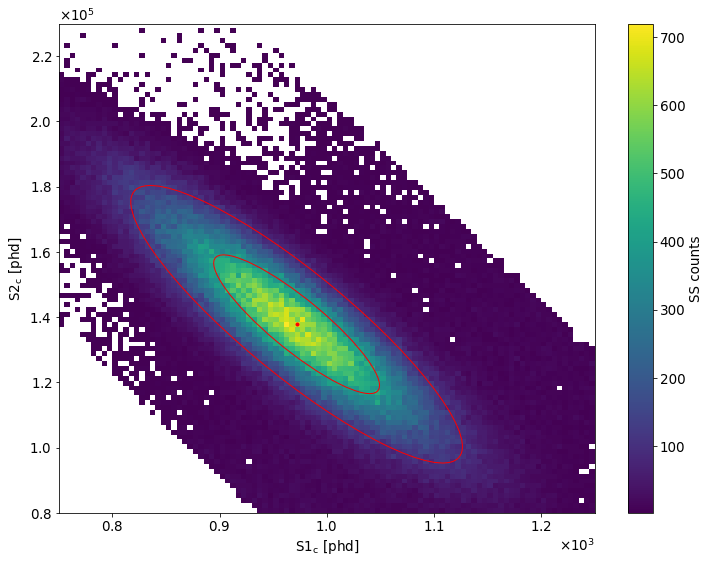

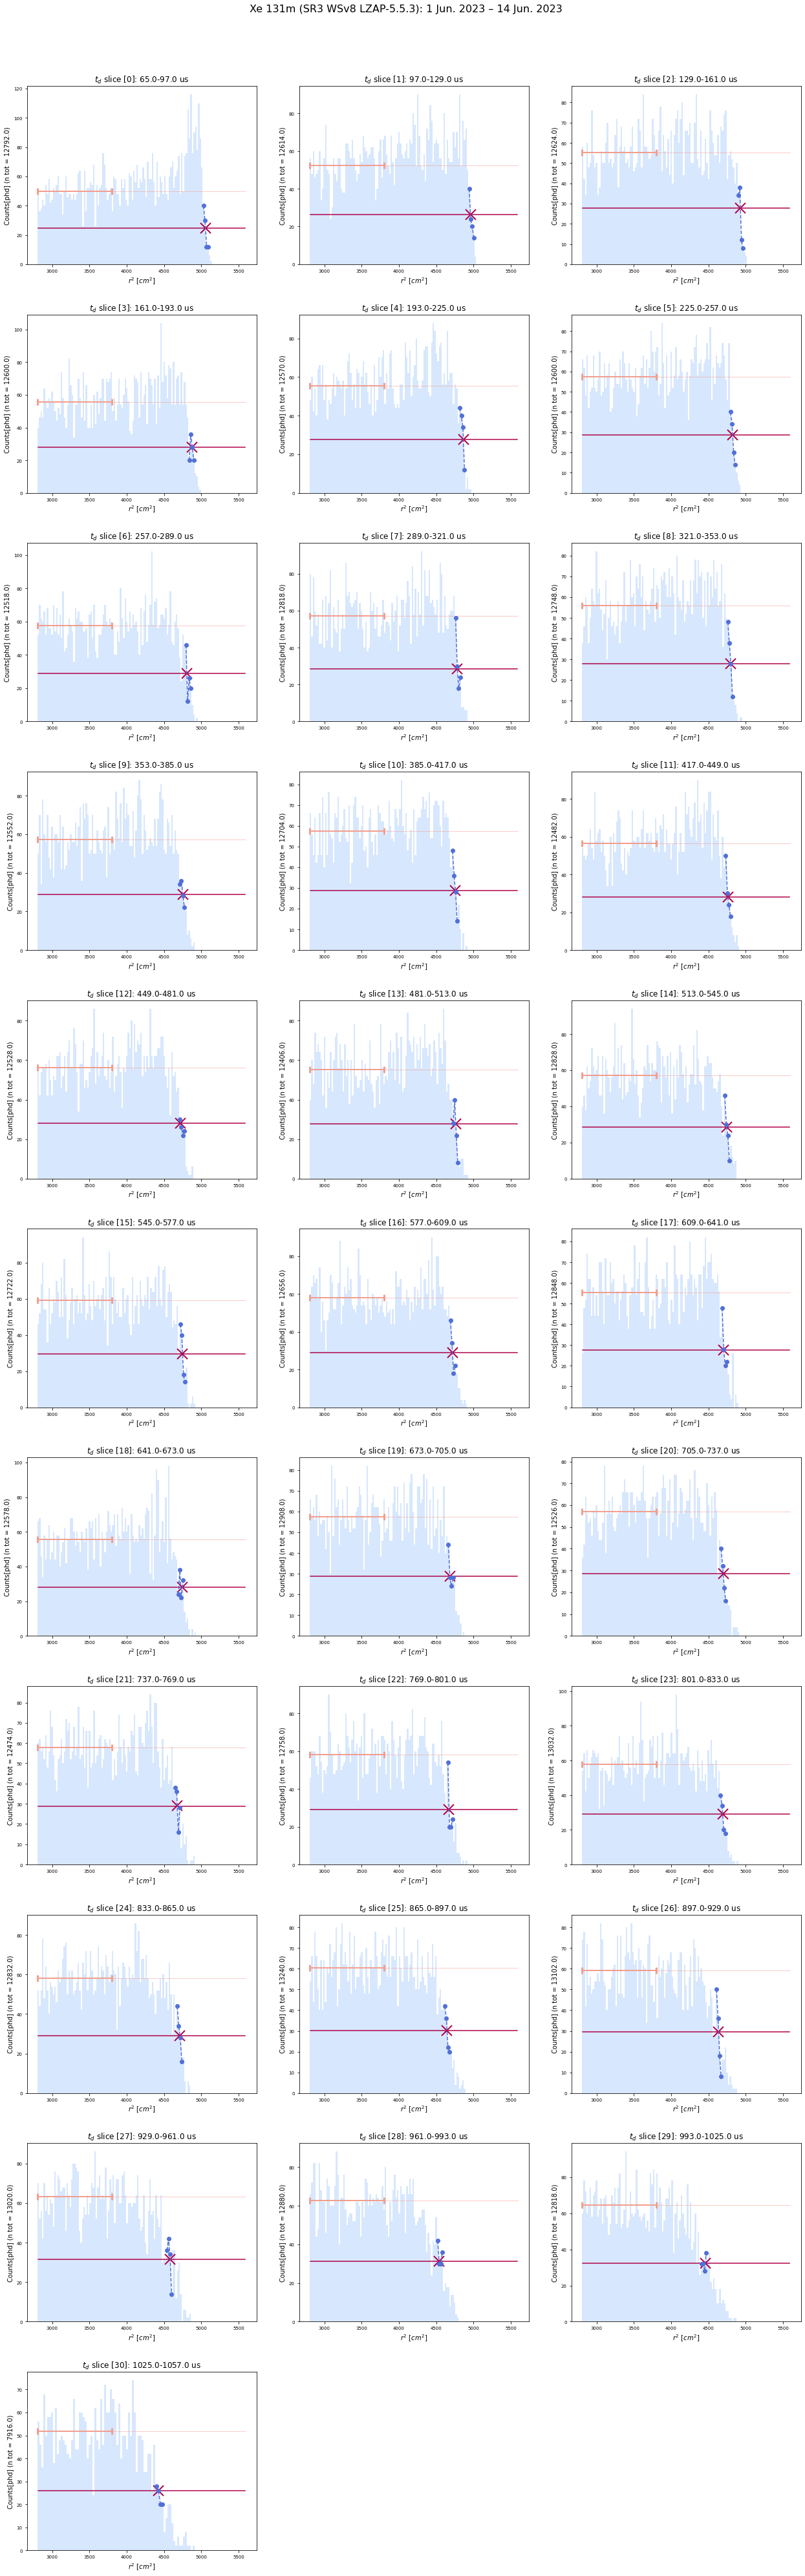

In [49]:

t_int_wall_dict5 = wall_interp(show_ell_plots = True, show_r2_plots = True, t_index=5, \
                               t_int_dict=time_int_dict, rqs_dict=rqs_dict, poly=polygon_main, \
                               cuts=cuts, dTslice_w=32, dTslice_i=min_dT, dTslice_f=max_dT, \
                               r2_drop=3.8e3, plots_per_row=3) 


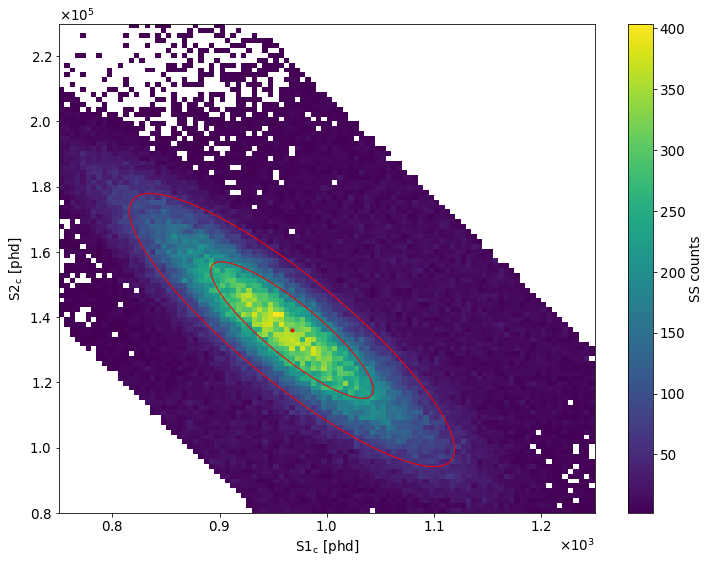

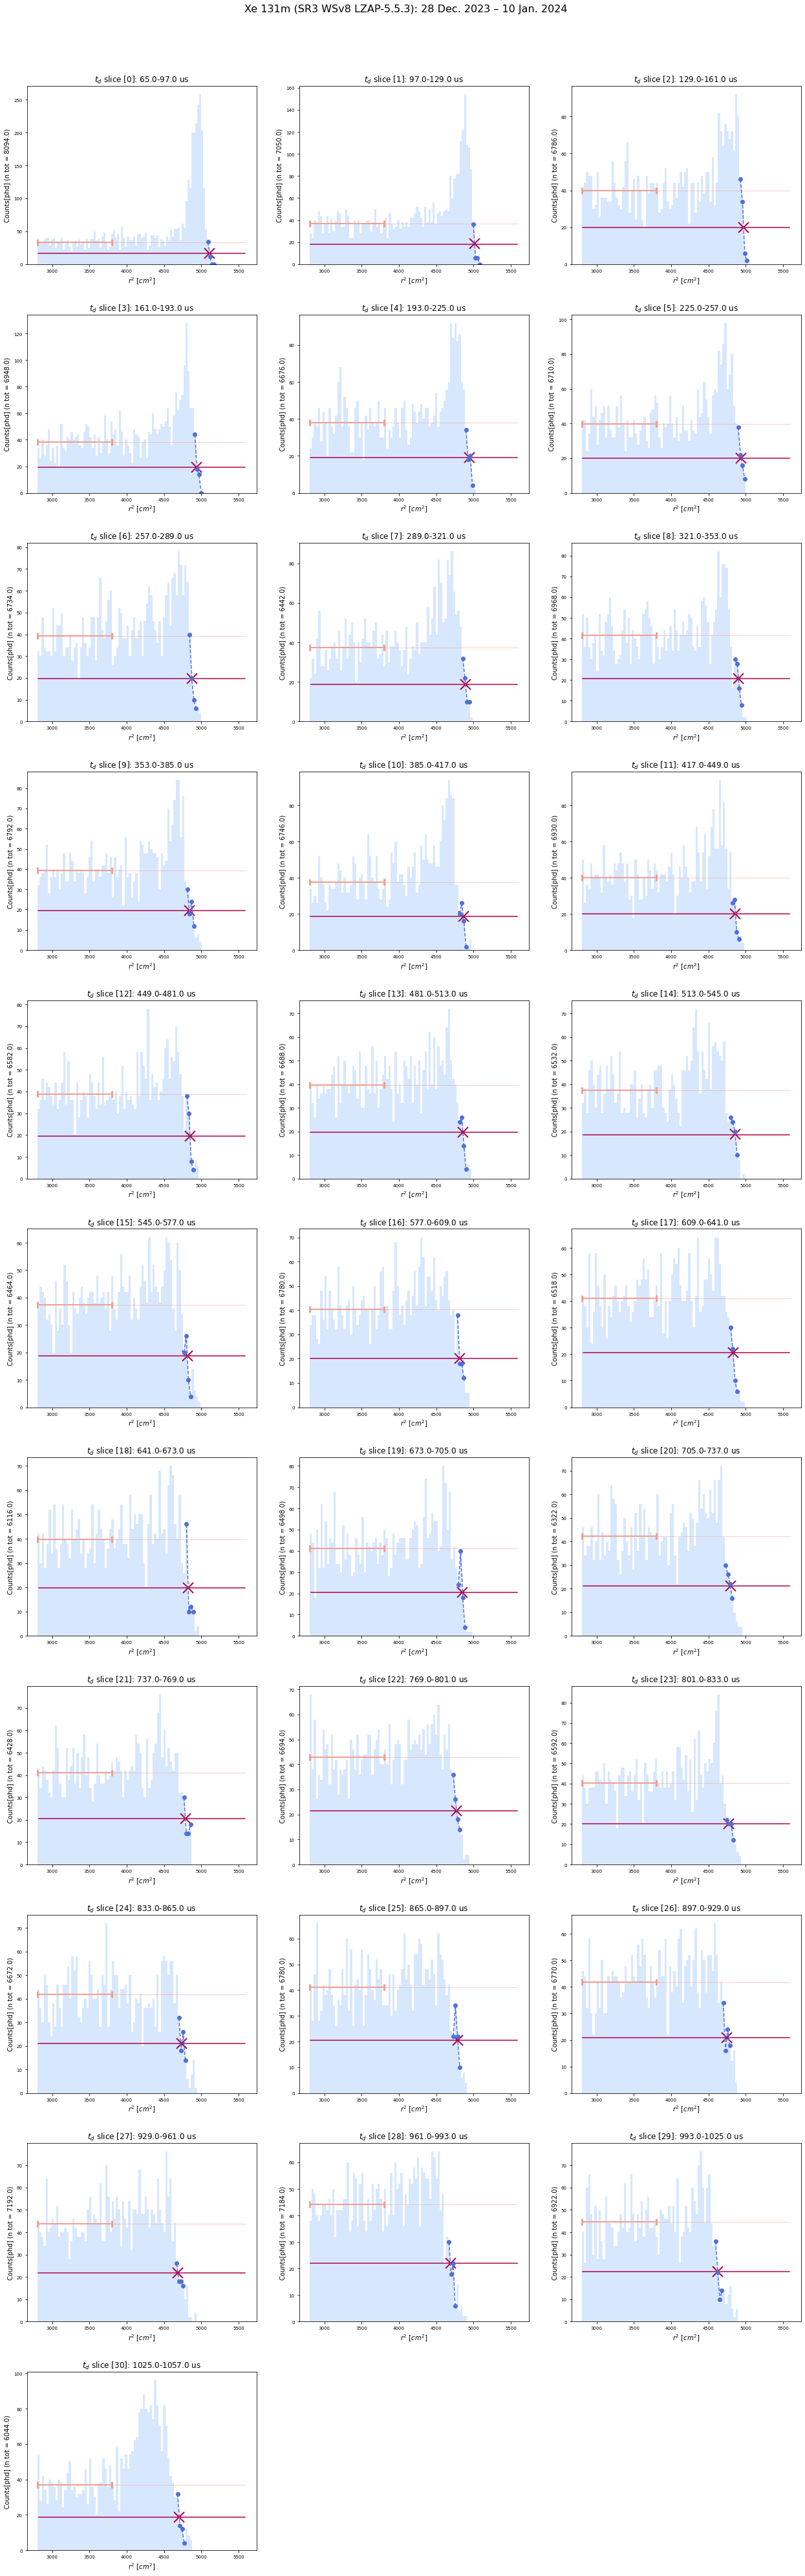

In [50]:

t_int_wall_dict21 = wall_interp(show_ell_plots = True, show_r2_plots = True, t_index=21, \
                                t_int_dict=time_int_dict, rqs_dict=rqs_dict, poly=polygon_main, \
                                cuts=cuts, dTslice_w=32, dTslice_i=min_dT, dTslice_f=max_dT, \
                                r2_drop=3.8e3, plots_per_row=3) 


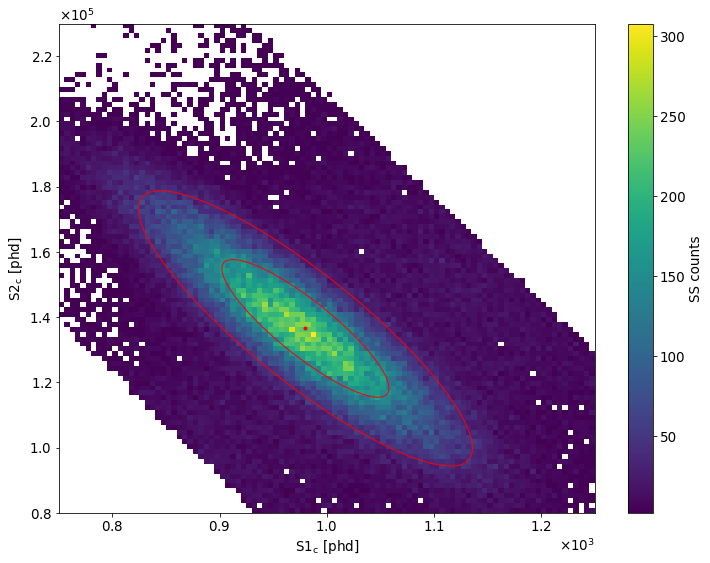

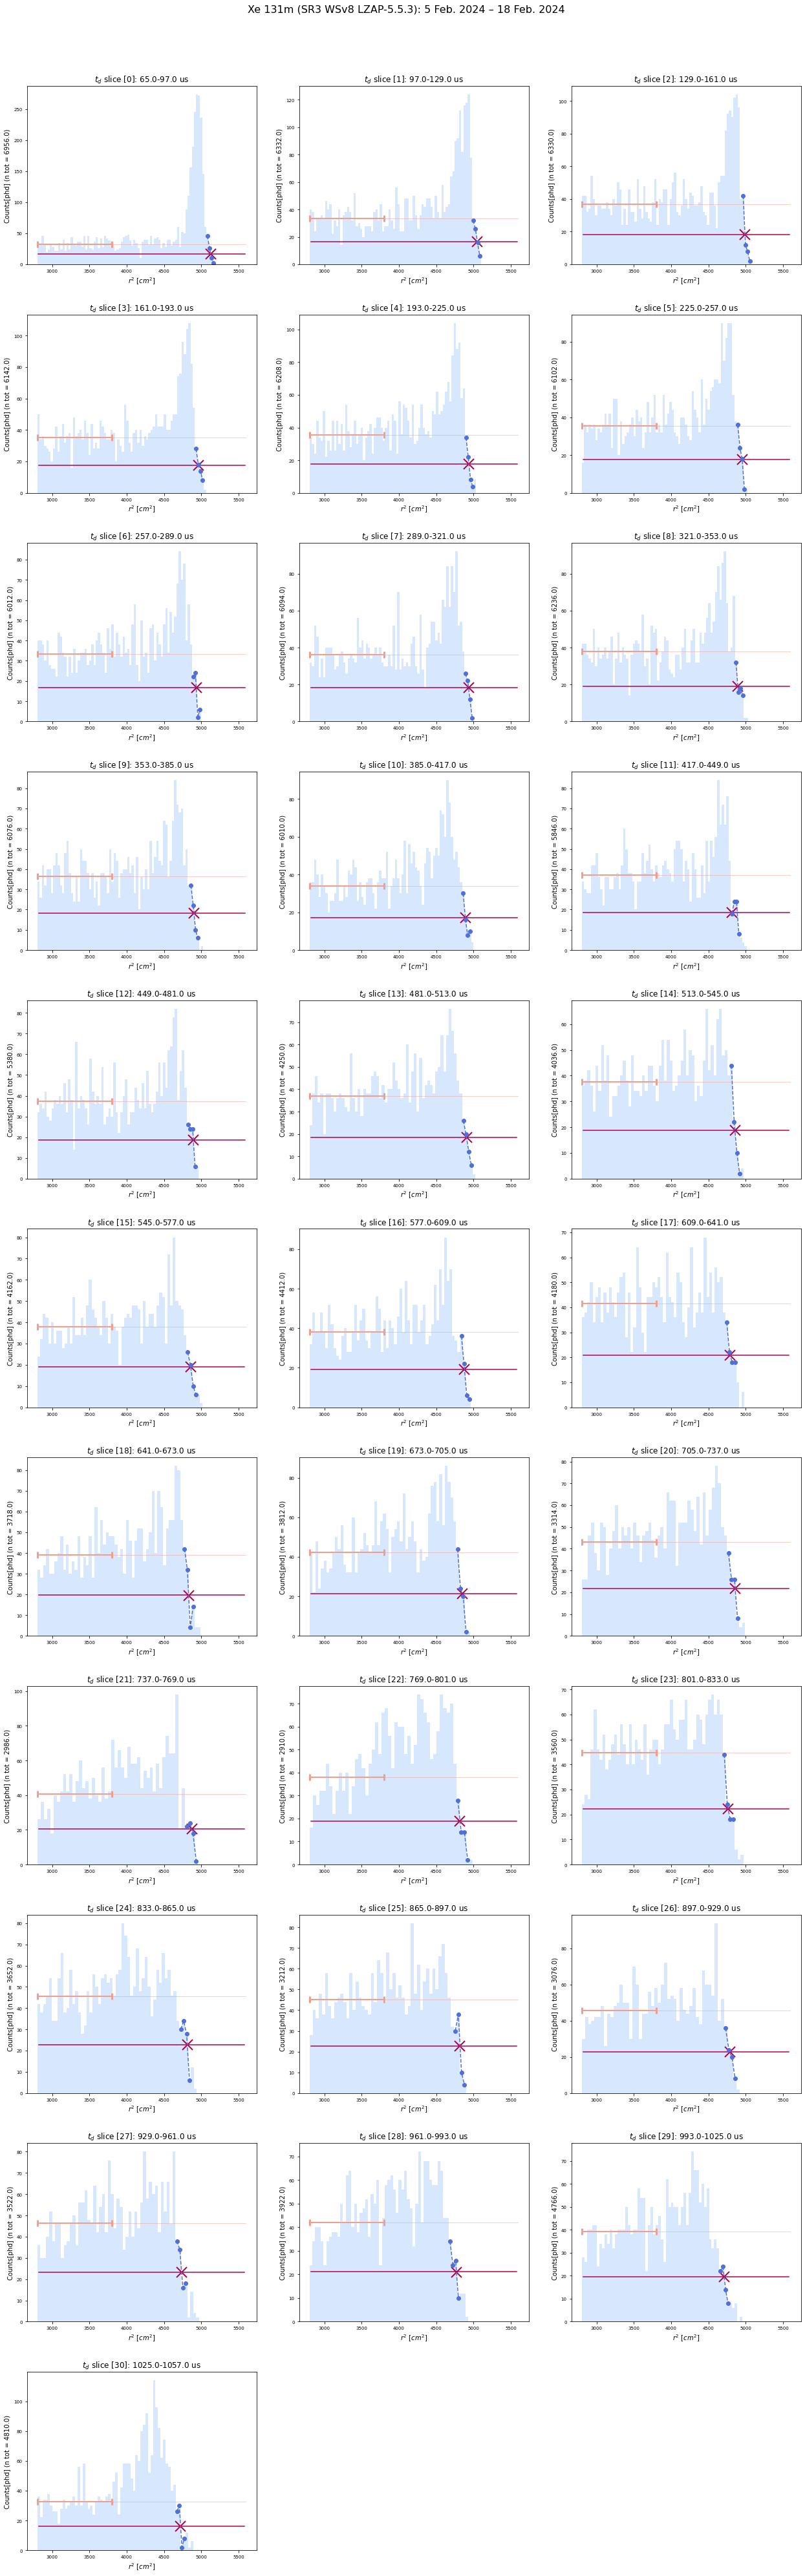

In [51]:

t_int_wall_dict24 = wall_interp(show_ell_plots = True, show_r2_plots = True, t_index=24, \
                                t_int_dict=time_int_dict, rqs_dict=rqs_dict, poly=polygon_main, \
                                cuts=cuts, dTslice_w=32, dTslice_i=min_dT, dTslice_f=max_dT, \
                                r2_drop=3.8e3, plots_per_row=3) 



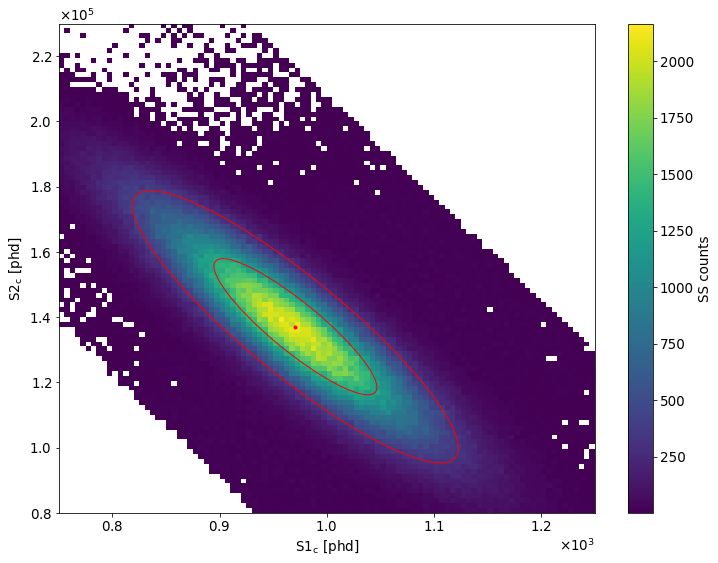

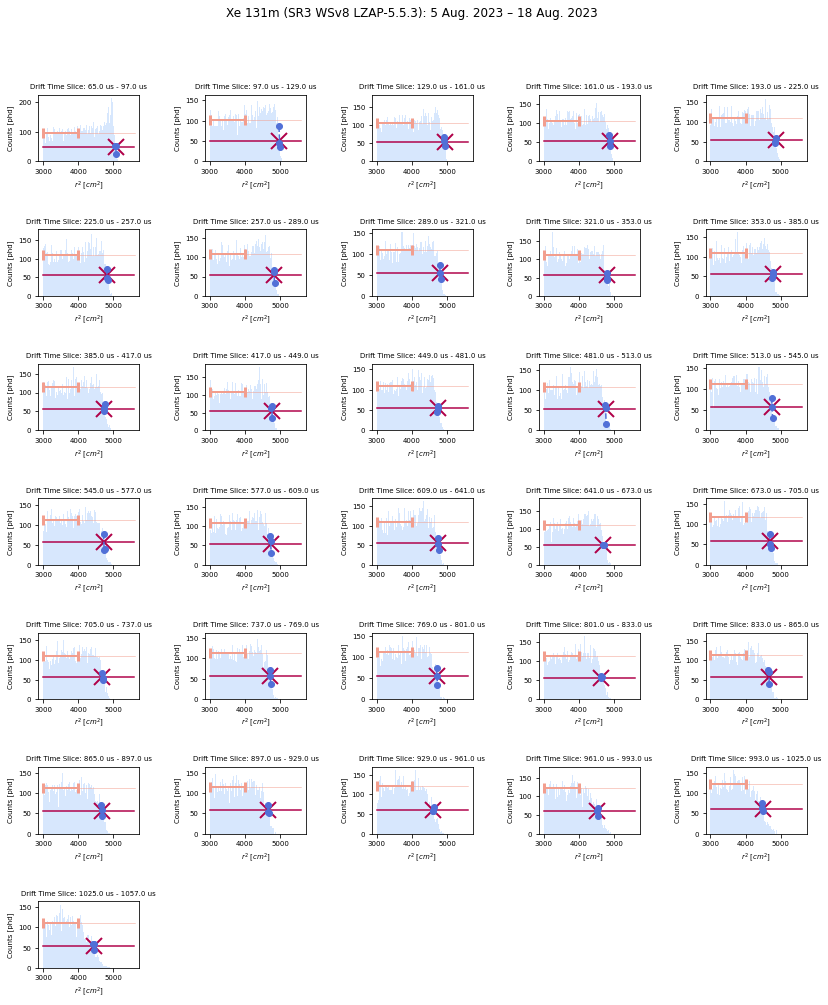

In [43]:

t_int_wall_dict10 = wall_interp(show_ell_plots = True, show_r2_plots = True, t_index=10, \
                             t_int_dict=time_int_dict, rqs_dict=rqs_dict, poly=polygon_main, \
                             cuts=cuts, dTslice_w=32, dTslice_i=min_dT, dTslice_f=max_dT) 

In [44]:
print_keys(t_int_wall_dict10)

variables in dictionary: t_int_wall_dict10

date_range
r2_hh
d_r2_hh
dT_i
dT_f
dT_mid
n_slice
num_bins


In [45]:
date_range10   = t_int_wall_dict10['date_range']
r2_hh10        = t_int_wall_dict10['r2_hh']
d_r2_hh10      = t_int_wall_dict10['d_r2_hh']
dT_i10         = t_int_wall_dict10['dT_i']
dT_f10         = t_int_wall_dict10['dT_f']
dT_mid10       = t_int_wall_dict10['dT_mid']
n_slice10      = t_int_wall_dict10['n_slice']
num_bins10     = t_int_wall_dict10['num_bins']
print()
print(f"date range:    {date_range10}")
print()
print(f"r2_hh10       = {r2_hh10}")
print()
print(f"d_r2_hh10     = {d_r2_hh10}")
print()
print(f"dT_i10       = {dT_i10}")
print()
print(f"dT_f10       = {dT_f10}")
print()
print(f"dT_mid10     = {dT_mid10}")
print()
print(f"n_slice10    = {n_slice10}")
print()
print(f"num_bins10   = {num_bins10}")


date range:    5 Aug. 2023 – 18 Aug. 2023

r2_hh10       = [5067.08078637 4975.23451286 4927.47541356 4877.55868113 4855.96930264
 4816.00934268 4828.6138179  4801.89313024 4795.85616544 4788.02152668
 4733.24702253 4763.57341798 4752.85963046 4763.60391805 4753.84432051
 4729.25638404 4729.96814018 4742.90172525 4698.94179894 4690.39039039
 4689.12280156 4718.43916455 4712.19886553 4636.52318986 4665.48548549
 4670.74536465 4653.79541979 4611.56965046 4530.92840315 4481.49209816
 4439.80998542]

d_r2_hh10     = [ 7.79708533  7.90682069  8.8534988   7.68770642 12.08565246  8.68208621
  8.96269637  7.77947638 10.260156   14.4990844  13.53043014  9.5615766
 14.97244078  7.90928439  7.95527556 10.23305987  8.8586348   8.28904753
 15.89669432  9.00577685  7.94247344  7.83280923  7.79266573  8.34402204
  9.46350915  7.72550219  8.04638947  8.1585399  14.2061736   8.6873908
  9.27951755]

dT_i10       = [  65.   97.  129.  161.  193.  225.  257.  289.  321.  353.  385.  417.
  449.  481.  5

In [46]:
print_keys(t_int_wall_dict0)
print()
date_range0   = t_int_wall_dict0['date_range']
r2_hh0        = t_int_wall_dict0['r2_hh']
d_r2_hh0      = t_int_wall_dict0['d_r2_hh']
n_slice0      = t_int_wall_dict0['n_slice']
num_bins0     = t_int_wall_dict0['num_bins']
print()
print(f"date range:    {date_range0}")
print()
print(f"r2_hh0       = {r2_hh0}")
print()
print(f"d_r2_hh0     = {d_r2_hh0}")
print()
print(f"n_slice0     = {n_slice0}")
print()
print(f"num_bins0    = {num_bins0}")

variables in dictionary: t_int_wall_dict0

date_range
r2_hh
d_r2_hh
dT_i
dT_f
dT_mid
n_slice
num_bins


date range:    27 Mar. 2023 – 9 Apr. 2023

r2_hh0       = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]

d_r2_hh0     = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]

n_slice0     = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]

num_bins0    = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]


In [47]:
t_int_wall_dict18 = wall_interp(show_ell_plots = False, show_r2_plots = False, t_index=18, \
                             t_int_dict=time_int_dict, rqs_dict=rqs_dict, poly=polygon_main, \
                             cuts=cuts, dTslice_w=32, dTslice_i=min_dT, dTslice_f=max_dT) 

In [48]:
t_int_wall_dict19 = wall_interp(show_ell_plots = False, show_r2_plots = False, t_index=19, \
                             t_int_dict=time_int_dict, rqs_dict=rqs_dict, poly=polygon_main, \
                             cuts=cuts, dTslice_w=32, dTslice_i=min_dT, dTslice_f=max_dT) 


In [84]:
print_keys(t_int_wall_dict19)
print()

date_range19 = t_int_wall_dict19['date_range']
r2_hh19      = t_int_wall_dict19['r2_hh']
n_slice19    = t_int_wall_dict19['n_slice']
print()
print(f"date range: {date_range19}")
print()
print(f"r2_hh19   = {r2_hh19}")
print()
print(f"n_slice19 = {n_slice19}")

variables in dictionary: t_int_wall_dict19

date_range
r2_hh
d_r2_hh
dT_i
dT_f
dT_mid
n_slice
num_bins


date range: 1 Dec. 2023 – 15 Dec. 2023

r2_hh19   = [5070.22165022 4961.8046618  4922.34424901 4869.23719836 4848.76126126
 4818.04185138 4815.81104914 4772.18822596 4795.23809524 4774.86551973
 4749.03251876 4804.95265908 4770.75486702 4759.66340172 4742.73988274
 4729.51701702 4734.82600247 4671.76053605 4740.99046415 4719.37754081
 4674.1105689  4690.68968969 4696.93554941 4710.486902   4709.46772015
 4680.06591497 4680.40169799 4559.63839946 4533.2837185  4504.56684755
 4456.03664889]

n_slice19 = [11210. 11036. 11106. 10750. 10866. 11144. 11104. 11440. 11160. 11510.
 11896. 11888. 11606. 11462. 11186. 10824. 10588.  9692.  9028.  9688.
  9266. 10034. 10266. 11294. 10756. 11298. 11800. 12914. 13332. 13196.
  9702.]


In [38]:
# NOW I HAVE TO FIGURE OUT HOW TO USE MY NEW FUNCTION TO LOOP THROUGH ALL TIME INTERVALS 
# HOW DO I GET IT TO GIVE ME A DICTIONARY WITH ALL THE INFO ABOUT ALL THE TIME INTERVALS

def get_wall_pos_t_int_dict(t_int_dict, rqs_dict, poly, cuts):
    
    # create blank dictionary
    all_t_int_wall_dict = {}
    
    for t in t_int_dict:
        
        one_t_int_wall_dict = wall_interp(t_index=t, t_int_dict=t_int_dict, rqs_dict=rqs_dict, 
                                          poly=poly, cuts=cuts, dTslice_w=32, dTslice_i=min_dT, 
                                          dTslice_f=max_dT, show_ell_plots=False, show_r2_plots=False) 
        
        # store results in 
        all_t_int_wall_dict[t] = one_t_int_wall_dict
    
    return all_t_int_wall_dict
        
    

In [52]:
all_t_int_wall_dict = get_wall_pos_t_int_dict(t_int_dict = time_int_dict, rqs_dict=rqs_dict, poly=polygon_main, cuts=cuts)

excluding [calendar time 0][drift time 0]

excluding [calendar time 0][drift time 1]

excluding [calendar time 0][drift time 2]

excluding [calendar time 0][drift time 3]

excluding [calendar time 0][drift time 4]

excluding [calendar time 0][drift time 5]

excluding [calendar time 0][drift time 6]

excluding [calendar time 0][drift time 7]

excluding [calendar time 0][drift time 8]

excluding [calendar time 0][drift time 9]

excluding [calendar time 0][drift time 10]

excluding [calendar time 0][drift time 11]

excluding [calendar time 0][drift time 12]

excluding [calendar time 0][drift time 13]

excluding [calendar time 0][drift time 14]

excluding [calendar time 0][drift time 15]

excluding [calendar time 0][drift time 16]

excluding [calendar time 0][drift time 17]

excluding [calendar time 0][drift time 18]

excluding [calendar time 0][drift time 19]

excluding [calendar time 0][drift time 20]

excluding [calendar time 0][drift time 21]

excluding [calendar time 0][drift time 22]

In [51]:
print_keys(all_t_int_wall_dict)

variables in dictionary: all_t_int_wall_dict

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


In [121]:
print(all_t_int_wall_dict)

{0: {'date_range': '27 Mar. 2023 – 9 Apr. 2023', 'r2_hh': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'd_r2_hh': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'dT_i': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'dT_f': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'dT_mid': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'n_slice': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'num_bins': array([0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [108]:
print(all_t_int_wall_dict[24])

{'date_range': '5 Feb. 2024 – 18 Feb. 2024', 'r2_hh': array([5113.68160613, 5013.7254902 , 4993.06806807, 4980.75919056,
       4917.54254254, 4944.96996997, 4892.62792204, 4892.84684685,
       4899.87438419, 4881.14585173, 4877.36952639, 4794.        ,
       4889.03801761, 4862.93674627, 4852.27846895, 4799.11101578,
       4859.01482878, 4846.1833927 , 4809.1016016 , 4824.26572914,
       4779.25557136, 4824.9666333 , 4809.78478478, 4724.41465856,
       4817.41009302, 4709.8747396 , 4782.81795309, 4725.55805806,
       4700.83178417, 4615.56556557, 4673.26644827]), 'd_r2_hh': array([34.87564811, 58.91127894, 34.09720474, 34.5509647 , 29.85811191,
       35.14308474, 35.14996271, 30.50612095, 31.78770314, 35.83216484,
       33.82722902, 60.08950452, 31.14683331, 51.31158202, 44.30014757,
       44.89175483, 37.97962337, 35.01902739, 57.42709878, 40.39857117,
       52.11225815, 44.97864123, 52.54883202, 41.52895147, 38.03250044,
       42.29708987, 41.63334278, 37.70844024, 35.827

In [43]:
# unpack the time interval wall dictionary 

def extract_data_from_nested_dict(dict):
    
    """
    this function essentially flattens a nested dictionary (dict by renaming variables 
    """
    # declare empty dictionary to hold the extracted data 
    extracted_data = {}
    
    for index, data in dict.items():
        
        # exlcude any empty data sets 
        if data is None:
            print(f"Data is None for index: {index}")
            continue
        
        for key, value in data.items():
            new_key = f"{key}_{index}"
            extracted_data[new_key] = value
            
    return extracted_data
        

In [53]:
all_data = extract_data_from_nested_dict(all_t_int_wall_dict)

Data is None for index: 2
Data is None for index: 3
Data is None for index: 4


In [95]:
date_range_19 = all_data['date_range_19']
print(date_range_19)

1 Dec. 2023 – 15 Dec. 2023


In [54]:
# Save all_data dictionary to a pickle file

with open('SR3_WSv4_Xe131m_wall-info-for-all-time-ints-2dgauss_5adj-bins.pickle', 'wb') as file:
    pickle.dump(all_data, file)

In [47]:
# get variables to use them 

# time interval 0
date_range_0  = all_data['date_range_0']
r2_hh_0       = all_data['r2_hh_0']
d_r2_hh_0     = all_data['d_r2_hh_0']
dT_i_0        = all_data['dT_i_0']
dT_f_0        = all_data['dT_f_0']
dT_mid_0      = all_data['dT_mid_0']
n_slice_0     = all_data['n_slice_0']
num_bins_0    = all_data['num_bins_0']

# time interval 1
date_range_1  = all_data['date_range_1']
r2_hh_1       = all_data['r2_hh_1']
d_r2_hh_1     = all_data['d_r2_hh_1']
dT_i_1        = all_data['dT_i_1']
dT_f_1        = all_data['dT_f_1']
dT_mid_1      = all_data['dT_mid_1']
n_slice_1     = all_data['n_slice_1']
num_bins_1    = all_data['num_bins_1']

# time interval 2
date_range_2  = all_data['date_range_2']
r2_hh_2       = all_data['r2_hh_2']
d_r2_hh_2     = all_data['d_r2_hh_2']
dT_i_2        = all_data['dT_i_2']
dT_f_2        = all_data['dT_f_2']
dT_mid_2      = all_data['dT_mid_2']
n_slice_2     = all_data['n_slice_2']
num_bins_2    = all_data['num_bins_2']

# time interval 3
date_range_3  = all_data['date_range_3']
r2_hh_3       = all_data['r2_hh_3']
d_r2_hh_3     = all_data['d_r2_hh_3']
dT_i_3        = all_data['dT_i_3']
dT_f_3        = all_data['dT_f_3']
dT_mid_3      = all_data['dT_mid_3']
n_slice_3     = all_data['n_slice_3']
num_bins_3    = all_data['num_bins_3']

# time interval 4
date_range_4  = all_data['date_range_4']
r2_hh_4       = all_data['r2_hh_4']
d_r2_hh_4     = all_data['d_r2_hh_4']
dT_i_4        = all_data['dT_i_4']
dT_f_4        = all_data['dT_f_4']
dT_mid_4      = all_data['dT_mid_4']
n_slice_4     = all_data['n_slice_4']
num_bins_4    = all_data['num_bins_4']

# time interval 5
date_range_5  = all_data['date_range_5']
r2_hh_5       = all_data['r2_hh_5']
d_r2_hh_5     = all_data['d_r2_hh_5']
dT_i_5        = all_data['dT_i_5']
dT_f_5        = all_data['dT_f_5']
dT_mid_5      = all_data['dT_mid_5']
n_slice_5     = all_data['n_slice_5']
num_bins_5    = all_data['num_bins_5']

# time interval 6
date_range_6  = all_data['date_range_6']
r2_hh_6       = all_data['r2_hh_6']
d_r2_hh_6     = all_data['d_r2_hh_6']
dT_i_6        = all_data['dT_i_6']
dT_f_6        = all_data['dT_f_6']
dT_mid_6      = all_data['dT_mid_6']
n_slice_6     = all_data['n_slice_6']
num_bins_6    = all_data['num_bins_6']

# time interval 7
date_range_7  = all_data['date_range_7']
r2_hh_7       = all_data['r2_hh_7']
d_r2_hh_7     = all_data['d_r2_hh_7']
dT_i_7        = all_data['dT_i_7']
dT_f_7        = all_data['dT_f_7']
dT_mid_7      = all_data['dT_mid_7']
n_slice_7     = all_data['n_slice_7']
num_bins_7    = all_data['num_bins_7']

# time interval 8
date_range_8  = all_data['date_range_8']
r2_hh_8       = all_data['r2_hh_8']
d_r2_hh_8     = all_data['d_r2_hh_8']
dT_i_8        = all_data['dT_i_8']
dT_f_8        = all_data['dT_f_8']
dT_mid_8      = all_data['dT_mid_8']
n_slice_8     = all_data['n_slice_8']
num_bins_8    = all_data['num_bins_8']

# time interval 9
date_range_9  = all_data['date_range_9']
r2_hh_9       = all_data['r2_hh_9']
d_r2_hh_9     = all_data['d_r2_hh_9']
dT_i_9        = all_data['dT_i_9']
dT_f_9        = all_data['dT_f_9']
dT_mid_9      = all_data['dT_mid_9']
n_slice_9     = all_data['n_slice_9']
num_bins_9    = all_data['num_bins_9']

# time interval 10
date_range_10 = all_data['date_range_10']
r2_hh_10      = all_data['r2_hh_10']
d_r2_hh_10    = all_data['d_r2_hh_10']
dT_i_10       = all_data['dT_i_10']
dT_f_10       = all_data['dT_f_10']
dT_mid_10     = all_data['dT_mid_10']
n_slice_10    = all_data['n_slice_10']
num_bins_10   = all_data['num_bins_10']

# time interval 11
date_range_11 = all_data['date_range_11']
r2_hh_11      = all_data['r2_hh_11']
d_r2_hh_11    = all_data['d_r2_hh_11']
dT_i_11       = all_data['dT_i_11']
dT_f_11       = all_data['dT_f_11']
dT_mid_11     = all_data['dT_mid_11']
n_slice_11    = all_data['n_slice_11']
num_bins_11   = all_data['num_bins_11']

# time interval 12
date_range_12 = all_data['date_range_12']
r2_hh_12      = all_data['r2_hh_12']
d_r2_hh_12    = all_data['d_r2_hh_12']
dT_i_12       = all_data['dT_i_12']
dT_f_12       = all_data['dT_f_12']
dT_mid_12     = all_data['dT_mid_12']
n_slice_12    = all_data['n_slice_12']
num_bins_12   = all_data['num_bins_12']

# time interval 13
date_range_13 = all_data['date_range_13']
r2_hh_13      = all_data['r2_hh_13']
d_r2_hh_13    = all_data['d_r2_hh_13']
dT_i_13       = all_data['dT_i_13']
dT_f_13       = all_data['dT_f_13']
dT_mid_13     = all_data['dT_mid_13']
n_slice_13    = all_data['n_slice_13']
num_bins_13   = all_data['num_bins_13']

# time interval 14
date_range_14 = all_data['date_range_14']
r2_hh_14      = all_data['r2_hh_14']
d_r2_hh_14    = all_data['d_r2_hh_14']
dT_i_14       = all_data['dT_i_14']
dT_f_14       = all_data['dT_f_14']
dT_mid_14     = all_data['dT_mid_14']
n_slice_14    = all_data['n_slice_14']
num_bins_14   = all_data['num_bins_14']

# time interval 15
date_range_15 = all_data['date_range_15']
r2_hh_15      = all_data['r2_hh_15']
d_r2_hh_15    = all_data['d_r2_hh_15']
dT_i_15       = all_data['dT_i_15']
dT_f_15       = all_data['dT_f_15']
dT_mid_15     = all_data['dT_mid_15']
n_slice_15    = all_data['n_slice_15']
num_bins_15   = all_data['num_bins_15']

# time interval 16
date_range_16 = all_data['date_range_16']
r2_hh_16      = all_data['r2_hh_16']
d_r2_hh_16    = all_data['d_r2_hh_16']
dT_i_16       = all_data['dT_i_16']
dT_f_16       = all_data['dT_f_16']
dT_mid_16     = all_data['dT_mid_16']
n_slice_16    = all_data['n_slice_16']
num_bins_16   = all_data['num_bins_16']

# time interval 19
date_range_19 = all_data['date_range_19']
r2_hh_19      = all_data['r2_hh_19']
d_r2_hh_19    = all_data['d_r2_hh_19']
dT_i_19       = all_data['dT_i_19']
dT_f_19       = all_data['dT_f_19']
dT_mid_19     = all_data['dT_mid_19']
n_slice_19    = all_data['n_slice_19']
num_bins_19   = all_data['num_bins_19']


In [ ]:
# define condition that will remove all events that don't pass vetoes

# vetoes
veto_list = (cxSR3_HSX,cxSR3_SPEX,cxSR3_S1rate,cxSR3_muonV,cxSR3_ETV,cxSR3_HSC,cxSR3_stinger,cxSR3_S1TBA,cxSR3_S2TBA,
             cxSR3_S2XYquality,cxSR3_S2width,cxSR3_narrowS2,cxSR3_S2earlypeak,cxSR3_S2risetime,cxSR3_FCRXY,cxSR3_burst_noise,
             cxSR3_buffer,cxSR3_SSwindow,cxSR3_skinV,cxSR3_skinVprompt,cxSR3_skinVdel,cxSR3_ODV,cxSR3_ODVprompt,cxSR3_ODVdel) 

# create blank conditions list
veto_cond = np.ones_like(cxSR1_HSX, dtype=bool)

for i in veto_list:
    veto_cond = veto_cond & i 

# define condition that 

# make mask to limit values in dT_fit to the range [65, 1044]

# drift time limits
min_dT = 65.
max_dT = 1044.

dT_cond = (dT_us > min_dT) & (dT_us < max_dT)

# define mask with all above conditions 

cuts = rough_xe131m_cond & dT_cond # & veto_cond
print(len(cuts))
print(sum(cuts))

In [81]:
# time_int_no_empty_days_dict, no_empty_days_mask, veto_list_no_empty_days, cuts_no_empty_days = get_time_ints_no_empty_days(t_bins_fine, \
#                                                                                                        t_bins_coarse, trigT_s[cuts], \
#                                                                                                        r2_cm2[cuts], cuts, veto_list)



no_empty_days_wall_dict = get_wall_pos_t_int_dict(t_int_dict = time_int_no_empty_days_dict, rqs_dict=rqs_dict_no_empty_days, poly=polygon_main, cuts=cuts_no_empty_days)

# no_empty_days_mask length: 4492723
# no_empty_days_mask no. of true : 3983400

IndexError: boolean index did not match indexed array along dimension 0; dimension is 4492723 but corresponding boolean dimension is 3983400